## Loading libraries and setting up directories

In [538]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm
from collections import Counter
import matplotlib
import matplotlib.patheffects as PathEffects
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

from svgpathtools import parse_path



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")




In [539]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
features_dir= os.path.join(results_dir,'features')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)  

if not os.path.exists(features_dir):
    os.makedirs(features_dir)
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/kushin/Documents/GitHub/semantic_parts/analysis/analysis_helpers.pyc'>

In [540]:
## helper dictionaries 
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}
CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

In [541]:
def cleanup_df(X):
    if 'Unnamed: 0' in X.columns:
        X = X.drop(columns=['Unnamed: 0'])
    return X

In [542]:
##Read in raw dataframe with subsetted data for 3 annotations per sketch

D=cleanup_df(pd.read_pickle(os.path.join(csv_dir, 'rawpckl')))

In [543]:
D.shape

(58947, 29)

In [7]:
D.sketch_id.nunique()

864

## Creating spline and stroke level dataframes for further analysis

In [8]:
## get the list of unique labels applied to sketches
unique_labels = np.unique(D.label.values)

## Removing Nones and obviously wrong super long lables
unique_labels = [i for i in unique_labels if i is not None]
unique_labels = [i for i in unique_labels if len(i)<900]

print 'we have {} unique labels'.format(len(unique_labels))

we have 24 unique labels


In [9]:
unique_cats= np.unique(D['category'])
##Create empty dictionary with categories as keys. We will use this to store part occurrence data for our categories
label_vect_dict = {unique_cats[0]:None,unique_cats[1]:None,unique_cats[2]:None,unique_cats[3]:None}

In [10]:
##Create vectors that contain the number of part instances in each sketch
num_annots=3

for category in unique_cats:
    DS= D[D['category']==category]
    unique_sketches_in_cat = np.unique(DS['sketch_id'])
    unique_labels_in_cat = np.unique(DS['label'])
    ## initialize matrix that has the correct dimensions
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)), dtype=int)
    unique_labels_in_cat= np.array(unique_labels_in_cat)
    for s,this_sketch in enumerate(unique_sketches_in_cat):
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSS = DS[DS['sketch_id']==this_sketch]
        annotation_ids = np.unique(DSS['annotation_id'].values)    
        for this_annotation in annotation_ids:
            DSA = DSS[DSS['annotation_id']==this_annotation]
            label_list = DSA.label.values
            for this_label in label_list:
                label_ind = unique_labels_in_cat==this_label
                label_vec[label_ind] += 1
            
        Label_Vec[s,:]=label_vec/num_annots
    label_vect_dict[category]= Label_Vec

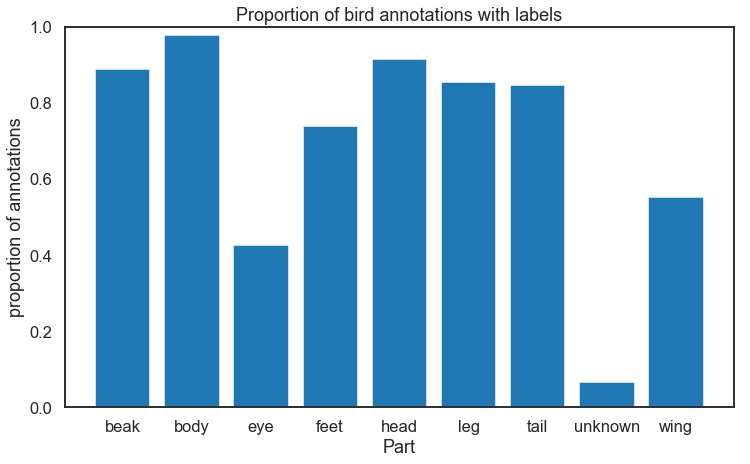

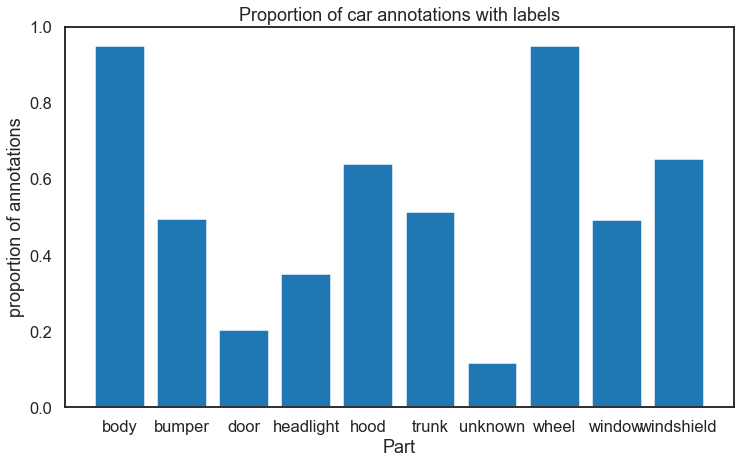

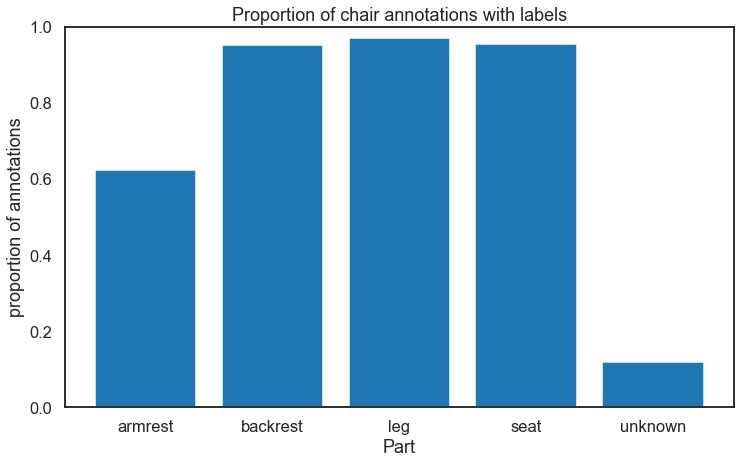

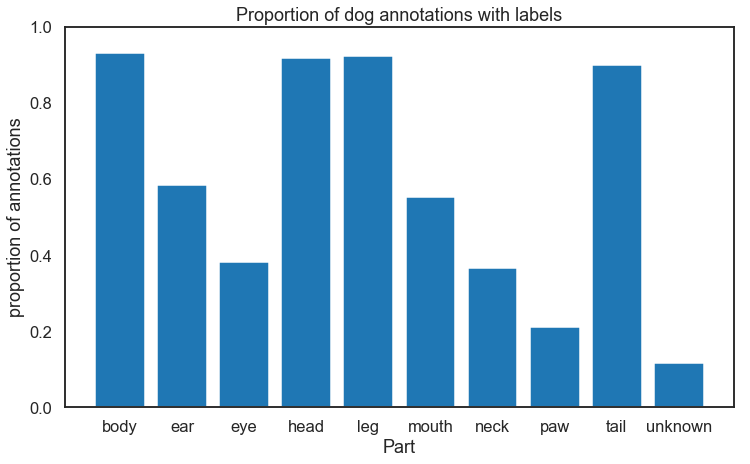

In [11]:
valid_labels=[]
valid_labels_dict={}
for category in unique_cats:
    vect = label_vect_dict[category]
    thresh = 50
    #print 'These are the labels that appear at least {} times:'.format(thresh)
    #print unique_labels[np.sum(Label_Vec,0)>thresh]
    unique_labels_in_cat = np.unique(D[D['category']==category]['label'])
    plot_labels= unique_labels_in_cat[np.sum(vect,0)>thresh]
    valid_labels_dict[category]=plot_labels
    valid_labels.append(plot_labels)


    prop_labels=[]
    for part in plot_labels:
        DS=D[D['category']==category]
        prop_labels.append(DS[DS['label']==part]['annotation_id'].nunique()/DS['annotation_id'].nunique())
    
    
    sns.set_context('talk')
    plt.figure(figsize=(12,7))
    plt.ylim(0,1)
    h = plt.bar(plot_labels,prop_labels)
    plt.title('Proportion of {} annotations with labels'.format(category))
    plt.ylabel('proportion of annotations')
    plt.xlabel('Part')
    
##flattening valid labels
valid_labels = [item for sublist in valid_labels for item in sublist]


In [12]:
len(np.unique(valid_labels))

24

In [13]:
#Creating a spline-level df where the modal label is set as the 'true' label for any given spline
spline_df= D.groupby('spline_id').agg(lambda x: Counter(x).most_common(1)[0][0])
spline_df.reset_index(level=0, inplace=True)

In [14]:
spline_df

spline_id              workerID  \
0       0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_0  m6ORYbrBlHuain-8m4U=   
1       0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_1  m6ORYbrBlHuain-8m4U=   
2      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_10  m6ORYbrBlHuain-8m4U=   
3      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_11  m6ORYbrBlHuain-8m4U=   
4      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_12  m6ORYbrBlHuain-8m4U=   
5      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_13  m6ORYbrBlHuain-8m4U=   
6      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_14  m6ORYbrBlHuain-8m4U=   
7      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_15  m6ORYbrBlHuain-8m4U=   
8      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_16  m6ORYbrBlHuain-8m4U=   
9      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_17  m6ORYbrBlHuain-8m4U=   
10      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_2  m6ORYbrBlHuain-8m4U=   
11      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_3  m6ORYbrBlHuain-8m4U=   
12      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_4  m6ORYbrBlHuain-8m4U=   
13      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_5  m6ORYbrBlHuain-8m4U=   
14      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_6  m6ORYbrBlHuain-8m4U=   
15      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_7  m6ORYbrBlHuain-8m4U=   
16      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_8  m6ORYbrBlHuain-8m4U=   
17      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_10_9  m6ORYbrBlHuain-8m4U=   
18      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_0  m6RzYbKte566jW-qm30=   
19      0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_1  m6RzYbKte566jW-qm30=   
20     0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_10  m6RzYbKte566jW-qm30=   
21     0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_11  m6RzYbKte566jW-qm30=   
22     0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_12  m6RzYbKte566jW-qm30=   
23     0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_13  m6RzYbKte566jW-qm30=   
24     0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_14  m6RzYbKte566jW-qm30=   
25     0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_15  m6RzYbKte566jW-qm30=   
26     0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_16  m6RzYbKte566jW-qm30=   
27     0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_17  m6RzYbKte566jW-qm30=   
28     0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_18  m6RzYbKte566jW-qm30=   
29     0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_19  m6RzYbKte566jW-qm30=   
...                                                ...                   ...   
19619   9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_26  m6N8aZ6poImwiYOfkoI=   
19620   9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_27  m6N8aZ6poImwiYOfkoI=   
19621   9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_28  m6N8aZ6poImwiYOfkoI=   
19622   9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_29  m6N8aZ6poImwiYOfkoI=   
19623    9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_3  m6N8aZ6poImwiYOfkoI=   
19624   9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_30  m6N8aZ6poImwiYOfkoI=   
19625    9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_4  m6N8aZ6poImwiYOfkoI=   
19626    9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_5  m6N8aZ6poImwiYOfkoI=   
19627    9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_6  m6N8aZ6poImwiYOfkoI=   
19628    9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_7  m6N8aZ6poImwiYOfkoI=   
19629    9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_8  m6N8aZ6poImwiYOfkoI=   
19630    9877-e1c91119-da46-40fa-82fe-17405ca56a3b_4_9  m6N8aZ6poImwiYOfkoI=   
19631    9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6_0  m6OEhLGokH2hi329go4=   
19632    9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6_1  m6OEhLGokH2hi329go4=   
19633   9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6_10  m6OEhLGokH2hi329go4=   
19634   9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6_11  m6OEhLGokH2hi329go4=   
19635   9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6_12  m6OEhLGokH2hi329go4=   
19636   9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6_13  m6OEhLGokH2hi329go4=   
19637   9877-e1c91119-da46-40fa-82fe-17405ca5

In [15]:
##Creating a stroke-level dataframe that takes the mode value of annotation for its children splines to set as its
##label value

from collections import Counter


from collections import OrderedDict
stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})


In [16]:
D['sketch_svg_string']

124      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
125      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
126      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
127      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
128      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
129      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
130      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
131      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
132      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
133      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
134      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
135      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
136      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
137      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
138      [M88,40c0,2.06264 -0.6772,18.1614 1,19c9.41403...
166      [M115,66c0,-25.54162 46.18401,-15.1264 59,-10c...
167      [M115,66c0,-25.54162 46.18401,-15.1264 59,-10c.

In [17]:
##Adding total arclength information to stroke dataframe
from svgpathtools import parse_path
import svgpathtools

def calculate_arclength(svg):
    try:
        arclength= parse_path(svg).length()
    except ZeroDivisionError:
        print 'zero div error'
        arclength = 0
    return arclength
        
                    

In [18]:
stroke_df['arc_length'] = stroke_df['svg'].apply(calculate_arclength)

## Creating feature vectors and normalizing 

In [19]:
###This is where we make a num unique labels * 2 X number of sketches vector 

feature_vec = np.zeros((len(stroke_df.sketch_id.unique()),len(valid_labels)*2), dtype=int)
ind=0
start_pos=0
end_pos=0
meta_list=[]
cols = ['sketch_id','target','condition','category','outcome']

for cat in unique_cats:
  
    DS= stroke_df[stroke_df['category']==cat]
    unique_labels_in_cat=valid_labels_dict[cat]
    unique_sketches_in_cat=DS['sketch_id'].unique()
    start_pos = end_pos
    end_pos+= len(unique_labels_in_cat)
    print start_pos, end_pos
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)*2), dtype=int)
    arc_length_vec = np.zeros((len(unique_sketches_in_cat),len(valid_labels_dict[cat])), dtype=int)
    for s,sketch in enumerate(unique_sketches_in_cat):
        
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        arc_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSA=DS[DS['sketch_id']==sketch]
      
        meta_list.append(pd.Series([DSA['sketch_id'],DSA['target'].unique(),DSA['condition'].unique(),DSA['category'].unique(),DSA['outcome'].unique()], index=cols))
        label_list = DSA.label.values        
        for label in label_list:
            if label in unique_labels_in_cat:
                label_ind = unique_labels_in_cat==label
                label_vec[label_ind] += 1
        for label in unique_labels_in_cat:
            DSB=DSA[DSA['label']==label]
            label_ind = unique_labels_in_cat==label
            arc_vec[label_ind] = DSB['arc_length'].sum()
            
        
        feature_vec[ind,start_pos:end_pos]=label_vec
        feature_vec[ind,start_pos+len(valid_labels):end_pos+len(valid_labels)]=arc_vec
        ind+=1
feature_vec_meta = pd.DataFrame(meta_list, columns=cols)

    


    

0 9
9 19
19 24
24 34


In [20]:
##Changing column values from np arrays to strings/boolean

def arr_to_str(arr):
    return (arr[0])
feature_vec_meta['target']=feature_vec_meta['target'].apply(arr_to_str)
feature_vec_meta['condition']=feature_vec_meta['condition'].apply(arr_to_str)
feature_vec_meta['category']=feature_vec_meta['category'].apply(arr_to_str)
feature_vec_meta['outcome']=feature_vec_meta['outcome'].apply(arr_to_str)



In [21]:
feature_df= pd.DataFrame(feature_vec, columns=[s + '_numstrokes' for s in valid_labels]+[s + '_total_arclength' for s in valid_labels])

In [22]:
##creating a compressed version of the feature df with no duplicates for parts

labs_numstrokes=[]
labs_total_arclength=[]
for lab in np.unique(valid_labels):
    labs_numstrokes.append(lab +'_numstrokes')
    labs_total_arclength.append(lab+'_total_arclength')
feature_df_labs=labs_numstrokes+labs_total_arclength   
feature_df_final= pd.DataFrame(columns=feature_df_labs)


for this_lab in feature_df_labs:
    duplicates=[col for col in feature_df if col.startswith(this_lab)]
    feature_df_final[this_lab]= feature_df[duplicates].sum(axis=1)
feature_df = feature_df_final

In [23]:
##Check to make sure the df looks okay
assert len(feature_df.columns)==len(np.unique(feature_df.columns))
feature_df.head()

armrest_numstrokes  backrest_numstrokes  beak_numstrokes  body_numstrokes  \
0                   0                    0                1                9   
1                   0                    0                1               27   
2                   0                    0                0               12   
3                   0                    0                1                9   
4                   0                    0                0                3   

   bumper_numstrokes  door_numstrokes  ear_numstrokes  eye_numstrokes  \
0                  0                0               0               2   
1                  0                0               0               0   
2                  0                0               0               0   
3                  0                0               0               0   
4                  0                0               0               4   

   feet_numstrokes  head_numstrokes          ...           \
0                2                0          ...            
1                8                6          ...            
2                2                0          ...            
3                6                0          ...            
4                5                0          ...            

   neck_total_arclength  paw_total_arclength  seat_total_arclength  \
0                     0                    0                     0   
1                     0                    0                     0   
2                     0                    0                     0   
3                     0                    0                     0   
4                     0                    0                     0   

   tail_total_arclength  trunk_total_arclength  unknown_total_arclength  \
0                   188                      0                        0   
1                   304                      0                        0   
2                    76                      0                        0   
3                     0                      0                        0   
4                     0                      0                        0   

   wheel_total_arclength  window_total_arclength  windshield_total_arclength  \
0                      0                       0                           0   
1                      0                       0                           0   
2                      0                       0                           0   
3                      0                       0                           0   
4                      0                       0                           0   

   wing_total_arclength  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

[5 rows x 48 columns]

In [24]:
#Normalizing within row within measure (numstrokes/arclength) 

feature_df.iloc[:,0:int(len(feature_df.columns)/2)]=feature_df.iloc[:,0:int(len(feature_df.columns)/2)].div(feature_df.iloc[:,0:int(len(feature_df.columns)/2)].sum(axis=1),axis=0)

feature_df.iloc[:,int(len(feature_df.columns)/2):int(len(feature_df.columns))]=feature_df.iloc[:,int(len(feature_df.columns)/2):int(len(feature_df.columns))].div(feature_df.iloc[:,int(len(feature_df.columns)/2):int(len(feature_df.columns))].sum(axis=1),axis=0)



In [25]:
###Execute this if we want to save a non-zscore matrix
run=True
if run==True:
    feature_df.to_csv(os.path.join(features_dir,'semantic_parts_sketch_features_compressed_non-whitened.csv'))
run=False    

In [26]:
#z-scoring within columns

columns=list(feature_df.columns)
for this_col in columns:
    feature_df[this_col]=(feature_df[this_col] - feature_df[this_col].mean())/feature_df[this_col].std(ddof=0)


In [27]:
feature_df.columns

Index([u'armrest_numstrokes', u'backrest_numstrokes', u'beak_numstrokes',
       u'body_numstrokes', u'bumper_numstrokes', u'door_numstrokes',
       u'ear_numstrokes', u'eye_numstrokes', u'feet_numstrokes',
       u'head_numstrokes', u'headlight_numstrokes', u'hood_numstrokes',
       u'leg_numstrokes', u'mouth_numstrokes', u'neck_numstrokes',
       u'paw_numstrokes', u'seat_numstrokes', u'tail_numstrokes',
       u'trunk_numstrokes', u'unknown_numstrokes', u'wheel_numstrokes',
       u'window_numstrokes', u'windshield_numstrokes', u'wing_numstrokes',
       u'armrest_total_arclength', u'backrest_total_arclength',
       u'beak_total_arclength', u'body_total_arclength',
       u'bumper_total_arclength', u'door_total_arclength',
       u'ear_total_arclength', u'eye_total_arclength', u'feet_total_arclength',
       u'head_total_arclength', u'headlight_total_arclength',
       u'hood_total_arclength', u'leg_total_arclength',
       u'mouth_total_arclength', u'neck_total_arclength',
    

### Saving out files as needed

In [28]:
feature_df.to_csv(os.path.join(features_dir,'semantic_parts_sketch_features_compressed.csv'))

In [29]:
np.save(os.path.join(features_dir, 'semantic_parts_sketch_features'),feature_vec)

In [30]:
feature_vec_meta.to_csv(os.path.join(features_dir,'semantic_parts_sketch_meta.csv'))

## Results : "Summer Analysis"

### Inter-annotator reliability

In [31]:
## Getting the number of unique labels assigned to a given spline across annotations
a=[]
num_diff_annots = []
for this_cat in unique_cats:
    DS=D[D['category']==this_cat]
    labels = valid_labels_dict[this_cat]
    unique_sketches_in_cat=np.unique(DS['sketch_id'])
    

   
    for this_sketch_id in unique_sketches_in_cat:
        DSA=DS[DS['sketch_id']==this_sketch_id]
        unique_splines = np.unique(DSA['cumulative_spline_num'])
        for i,this_spline in enumerate(unique_splines):
            DSB =DSA[DSA['cumulative_spline_num']==this_spline]
            numannots= 4-len(np.unique(DSB['label']))
            if len(np.unique(DSB['label'])) == 3:
                a.append(this_sketch_id)
            if numannots==0:
                numannots=1
            num_diff_annots.append(numannots)

([<matplotlib.axis.XTick at 0x10d95ecd0>,
 <a list of 3 Text xticklabel objects>)

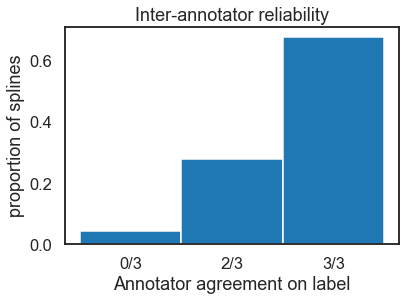

In [32]:
#plotting variability in spline annots
plt.figure(figsize=(4,4))
h= plt.hist(num_diff_annots, bins= range(1,5), align='left', density='True')
plt.title('Inter-annotator reliability')
plt.ylabel('proportion of splines')
plt.xlabel('Annotator agreement on label')
plt.xticks([1,2,3],['0/3','2/3','3/3'])

In [33]:
print h

(array([0.04371724, 0.27858924, 0.67769352]), array([1, 2, 3, 4]), <a list of 3 Patch objects>)


### Stroke-part relationships

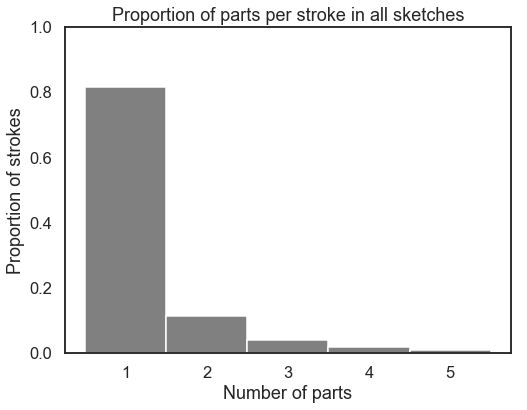

In [68]:
spline_annots_per_stroke = []
for this_cat in unique_cats:
    labels = valid_labels_dict[this_cat]
    DS=spline_df[spline_df['category']==this_cat]
    unique_sketches_in_cat= np.unique(DS['sketch_id'])
    for this_sketch_id in unique_sketches_in_cat:
        DSA=DS[DS['sketch_id']==this_sketch_id]
        unique_strokes = np.unique(DSA['stroke_num'])
        for i,this_stroke in enumerate(unique_strokes):
            DSB =DSA[DSA['stroke_num']==this_stroke]
            numlabels= DSB['label'].nunique()
            spline_annots_per_stroke.append(numlabels)
            


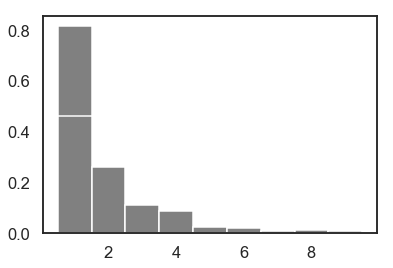

In [417]:
# spline_dfs = spline_df[spline_df['condition']=='further']
# stroke_dfs = stroke_df[stroke_df['condition']=='further']
spline_dfs = spline_df
stroke_dfs = stroke_df
spline_annots_per_stroke = []
for this_cat in unique_cats:
    labels = valid_labels_dict[this_cat]
    DS=spline_dfs[spline_dfs['category']==this_cat]
    unique_sketches_in_cat= np.unique(DS['sketch_id'])
    for this_sketch_id in unique_sketches_in_cat:
        DSA=DS[DS['sketch_id']==this_sketch_id]
        unique_strokes = np.unique(DSA['stroke_num'])
        for i,this_stroke in enumerate(unique_strokes):
            DSB =DSA[DSA['stroke_num']==this_stroke]
            numlabels= DSB['label'].nunique()
            spline_annots_per_stroke.append(numlabels)
h= plt.hist(spline_annots_per_stroke, bins =[1,2,3,4,5,6], align='left', density="True", color='grey')
pps_series = pd.Series(np.array([h[0][0],h[0][1],h[0][2:].sum()]), index=['1', '2', '3+'], \
                     )

strokes_per_part = []
for this_cat in unique_cats:
    DS=stroke_dfs[stroke_dfs['category']==this_cat]
    unique_sketches_in_cat= np.unique(DS['sketch_id'])
    for this_sketch_id in unique_sketches_in_cat:
        DSA=DS[DS['sketch_id']==this_sketch_id]
        parts_in_sketch = np.unique(DSA['label'])
        for i,this_part in enumerate(parts_in_sketch):
            DSB =DSA[DSA['label']==this_part]
            numstrokes= DSB['stroke_num'].nunique()
            strokes_per_part.append(numstrokes)
h= plt.hist(strokes_per_part, bins =[1,2,3,4,5,6,7,8,9,10], align='left', density="True", color ='grey')
spp_series = pd.Series(np.array([h[0][0],h[0][1],h[0][2:].sum()]), index=['1', '2', '3+'], \
                     )
     


In [418]:
print pps_series, spp_series

1     0.816374
2     0.113710
3+    0.069916
dtype: float64 1     0.460859
2     0.260153
3+    0.278988
dtype: float64


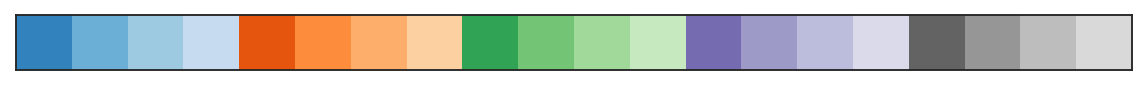

In [419]:
colors = sns.color_palette('tab20c')
sns.palplot(colors)

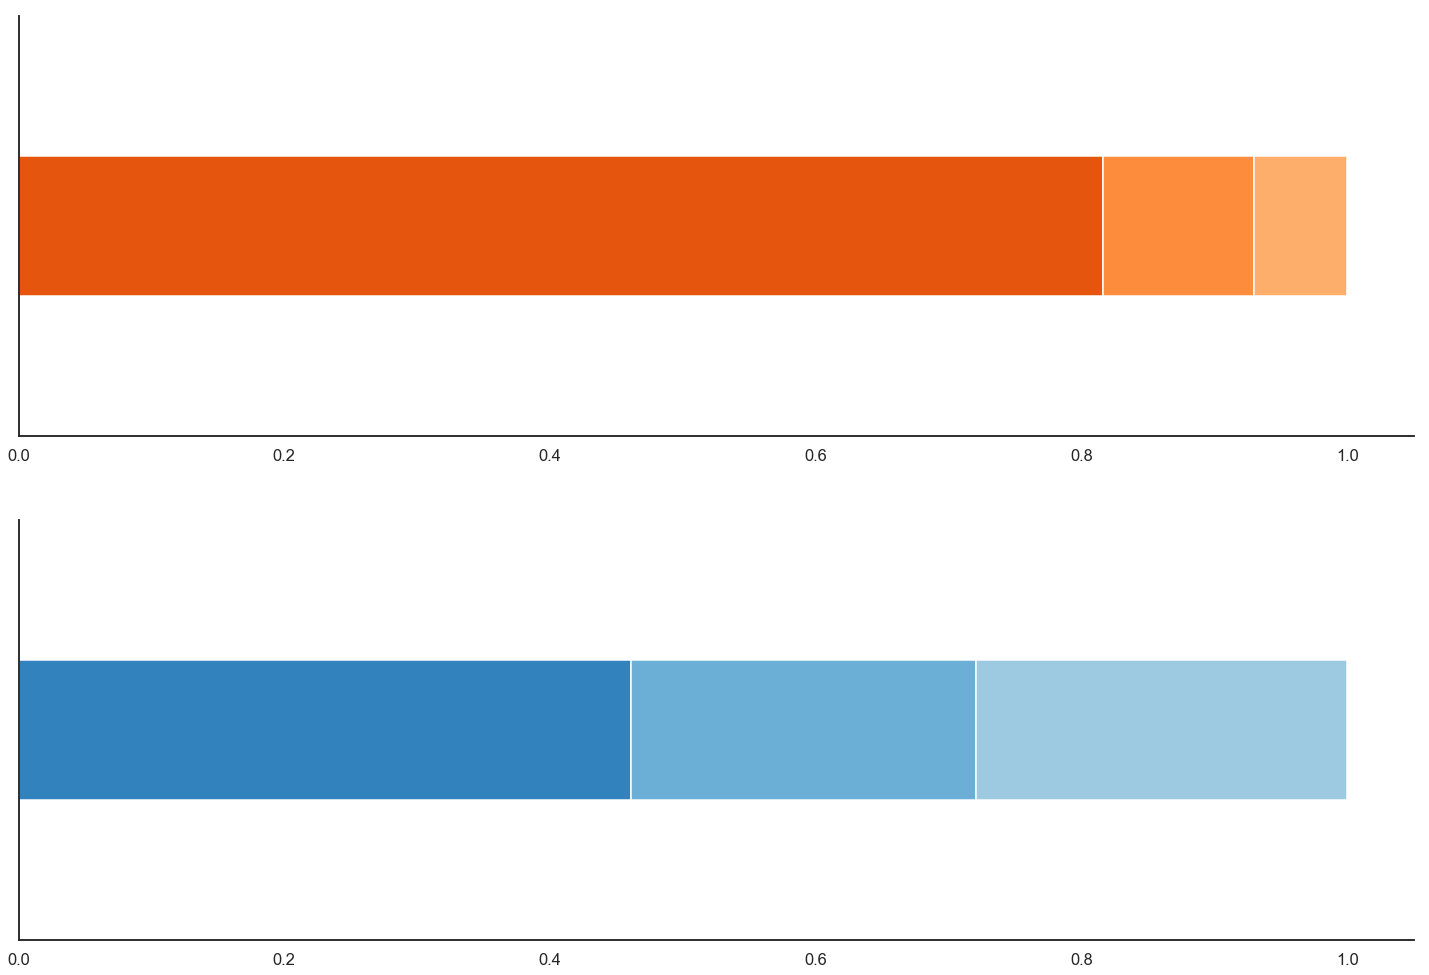

In [426]:
fig = plt.figure(figsize=(25,17))
colors = sns.color_palette('tab20c')

ax1 = fig.add_subplot(212) # Create matplotlib axes
ax2 = fig.add_subplot(211)


# pd.DataFrame(spp_series).T.plot(ax=axes[0,1]).bar(stacked=True,legend=False, width =0.2)
# pd.DataFrame(pps_series).T.plot(ax=axes[0,0]).bar(stacked=True,legend=False, width =0.2)


b1=pd.DataFrame(spp_series).T.plot.barh(stacked=True,legend=False, width =0.25,ax=ax1, color=[colors[0],colors[1],colors[2]])
b2=pd.DataFrame(pps_series).T.plot.barh(stacked=True,legend=False, width =0.25,ax=ax2, color=[colors[4],colors[5],colors[6]])




for item in b1.get_xticklabels():
     item.set_rotation(0)

for item in b2.get_xticklabels():
     item.set_rotation(0)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlabel('',labelpad = 15)
ax2.set_xlabel('',labelpad= 15)
ax1.set_yticks([])
ax2.set_yticks([])
plt.subplots_adjust(wspace=1)



#plt.savefig(os.path.join(plot_dir,'stroke_part_relationship'),edgecolor='w',bbox_inches='tight',dpi=500)



In [453]:
c_pps= np.load(os.path.join(features_dir,'c_pps.npy'))
c_pps = c_pps/c_pps.sum(axis=1)[:,None]
c_spp= np.load(os.path.join(features_dir,'c_spp.npy'))
c_spp = c_spp/c_spp.sum(axis=1)[:,None]
f_pps= np.load(os.path.join(features_dir,'f_pps.npy'))
f_pps = f_pps/f_pps.sum(axis=1)[:,None]
f_spp= np.load(os.path.join(features_dir,'f_spp.npy'))
f_spp = f_spp/f_spp.sum(axis=1)[:,None]


c_pps[:,1]=c_pps[:,1]+c_pps[:,2]
c_pps=np.delete(c_pps,2,1)
f_pps[:,1]=f_pps[:,1]+f_pps[:,2]
f_pps=np.delete(f_pps,2,1)



c_spp[:,1]=c_spp[:,1]+c_spp[:,2]
c_spp=np.delete(c_spp,2,1)
f_spp[:,1]=f_spp[:,1]+f_spp[:,2]
f_spp=np.delete(f_spp,2,1)


In [464]:
#Parts per stroke

c_pps_CI = np.percentile(c_pps[:,1],2.5).round(3),np.percentile(c_pps[:,1],97.5).round(3)
f_pps_CI = np.percentile(f_pps[:,1],2.5).round(3),np.percentile(f_pps[:,1],97.5).round(3)

In [467]:
print c_pps_CI, f_pps_CI

(0.161, 0.188) (0.179, 0.209)


In [465]:
#Strokes per part
c_spp_CI = np.percentile(c_spp[:,1],2.5).round(3),np.percentile(c_spp[:,1],97.5).round(3)
f_spp_CI = np.percentile(f_spp[:,1],2.5).round(3),np.percentile(f_spp[:,1],97.5).round(3)

In [474]:
print c_spp_CI, f_spp_CI

(0.537, 0.586) (0.499, 0.546)


In [473]:
print np.mean(f_pps[:,0]),np.mean(f_pps[:,1])

0.8063809252661006 0.1936190747338994


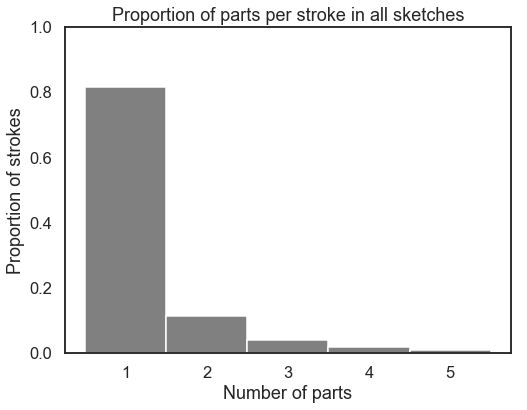

In [35]:
plt.figure(figsize=(8,6))
h= plt.hist(spline_annots_per_stroke, bins =[1,2,3,4,5,6], align='left', density="True", color='grey')
plt.title('Proportion of parts per stroke in all sketches')
plt.ylabel('Proportion of strokes')
plt.xlabel('Number of parts')
plt.ylim(0,1)
plt.savefig(os.path.join(plot_dir,'parts_per_stroke'),edgecolor='w',bbox_inches='tight')
pps_series = pd.Series(np.array([h[0][0],h[0][1],h[0][2],h[0][3:].sum()]), index=['1', '2', '3', '>3'], \
                     )

In [36]:
print h

(array([0.81637427, 0.1137102 , 0.03937622, 0.01923327, 0.01130604]), array([1, 2, 3, 4, 5, 6]), <a list of 5 Patch objects>)


In [37]:
strokes_per_part = []
for this_cat in unique_cats:
    DS=stroke_df[stroke_df['category']==this_cat]
    unique_sketches_in_cat= np.unique(DS['sketch_id'])
    for this_sketch_id in unique_sketches_in_cat:
        DSA=DS[DS['sketch_id']==this_sketch_id]
        parts_in_sketch = np.unique(DSA['label'])
        for i,this_part in enumerate(parts_in_sketch):
            DSB =DSA[DSA['label']==this_part]
            numstrokes= DSB['stroke_num'].nunique()
            strokes_per_part.append(numstrokes)


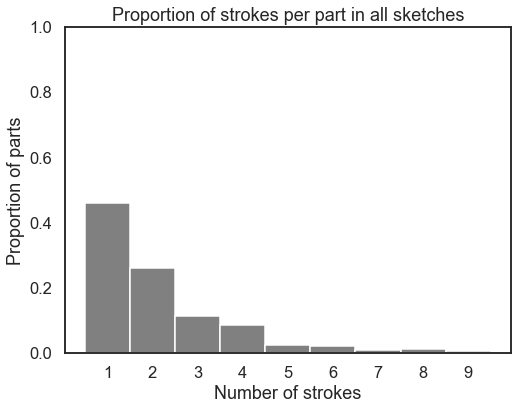

In [38]:
plt.figure(figsize=(8,6))
h= plt.hist(strokes_per_part, bins =[1,2,3,4,5,6,7,8,9,10], align='left', density="True", color ='grey')
plt.title('Proportion of strokes per part in all sketches')
plt.ylabel('Proportion of parts')
plt.xlabel('Number of strokes')
plt.xticks(np.arange(1,10))
plt.ylim(0,1)
plt.savefig(os.path.join(plot_dir,'strokes_per_part'),edgecolor='w',bbox_inches='tight')
spp_series = pd.Series(np.array([h[0][0],h[0][1],h[0][2],h[0][3:].sum()]), index=['1', '2', '3', '>3'], \
                      )


In [39]:
print h


(array([0.46085933, 0.26015303, 0.11330194, 0.08828723, 0.02501471,
       0.02266039, 0.0097116 , 0.01236021, 0.00765156]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), <a list of 9 Patch objects>)


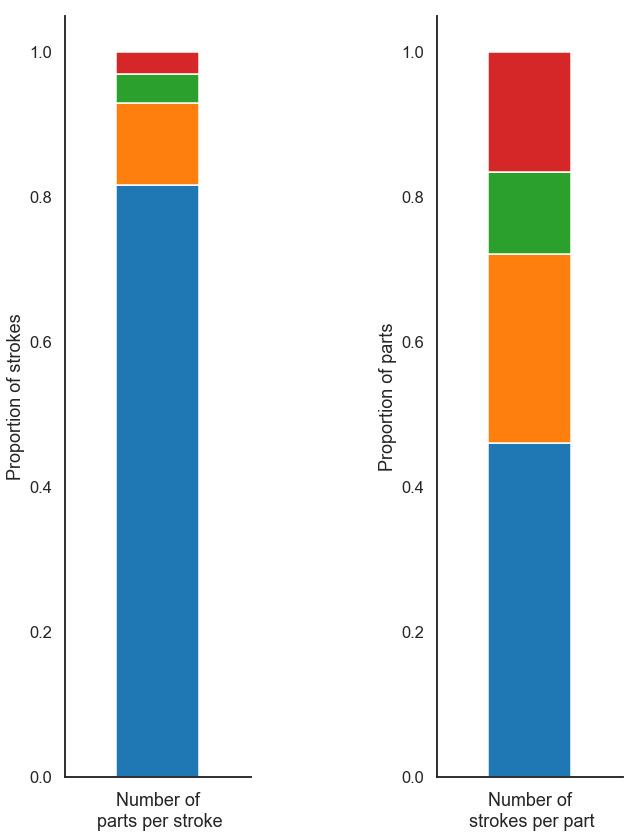

/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


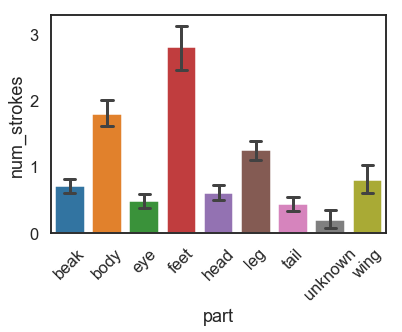

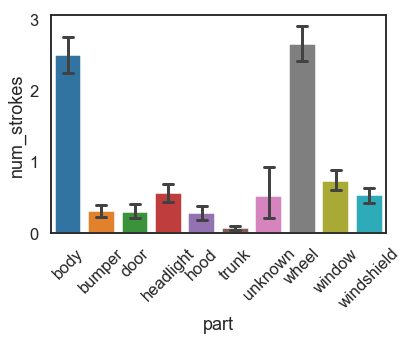

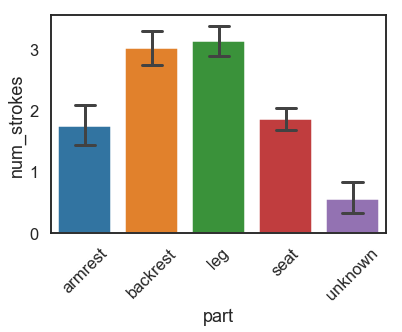

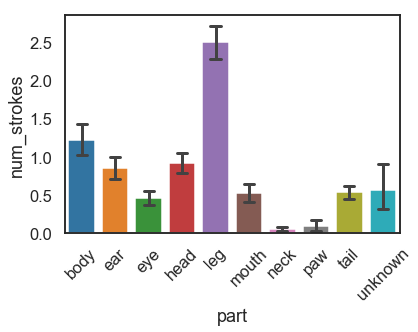

In [41]:
for this_cat in unique_cats:
    DS=stroke_df[stroke_df['category']==this_cat]
    labels= valid_labels_dict[this_cat]
    strokes_in_part_vect = np.zeros((len(np.unique(DS['sketch_id']))*len(labels),3), dtype='|a1000')
    ind=0
    for this_sketch in np.unique(DS['sketch_id']):    
        DSA= DS[DS['sketch_id']==this_sketch]
        for this_label in labels:
            DSB=DSA[DSA['label']==this_label]
            strokes_in_part_vect[ind,]=[this_sketch, this_label,len(np.unique(DSB['stroke_num']))]
            ind+=1
    strokes_in_part_vect=strokes_in_part_vect[~np.all(strokes_in_part_vect == '', axis=1)]
    strokes_in_part_df= pd.DataFrame(strokes_in_part_vect, columns=['sketch_id','part','num_strokes'])
    strokes_in_part_df['num_strokes']=pd.to_numeric(strokes_in_part_df['num_strokes'])
    plt.figure()
    b=sns.barplot(x='part',y='num_strokes',data=strokes_in_part_df,ci=95,capsize=0.3, errwidth= 3)
    for item in b.get_xticklabels():
        item.set_rotation(45)

### Part-streak analysis

In [42]:
##Creating a dictionary of sketch_id with associated part sequences
seq_dict={}
for this_sketch in np.unique(stroke_df['sketch_id']):
    parts_list=[]
    DS=stroke_df[stroke_df['sketch_id']==this_sketch]
    for i, row in DS.iterrows():
        parts_list.append(stroke_df['label'][i])
    seq_dict[this_sketch]=parts_list

In [43]:
##functions for getting 'mean streak_length' from a particular sketch for ground truth and scrambled part orders

import random

def get_mean_streak(sketch_id):
    parts = seq_dict[sketch_id]
    streak_counter=1
    list_of_streaks=[]
    for obj in range(len(parts)-1):
        if parts[obj]==parts[obj+1]:
            streak_counter+=1
        else:
            list_of_streaks.append(streak_counter)
            streak_counter=1 
    list_of_streaks.append(streak_counter)
    return np.mean(list_of_streaks)

def get_scramble_mean_streak(sketch_id):
    parts = seq_dict[sketch_id]
    scram_parts=random.sample(parts,len(parts))
    streak_counter=1
    list_of_streaks=[]
    for obj in range(len(scram_parts)-1):
        if scram_parts[obj]==scram_parts[obj+1]:
            streak_counter+=1
        else:
            list_of_streaks.append(streak_counter)
            streak_counter=1 
    list_of_streaks.append(streak_counter)
    return np.mean(list_of_streaks)

In [44]:
#Iterating over all sketches to get mean streakiness for each sketch_id

gt_streak_mean={}
for this_cat in unique_cats:
    DS= stroke_df[stroke_df['category']==this_cat]
    streak_mean_list=[]
    for this_sketch in np.unique(DS['sketch_id']):
        streak_mean_list.append(get_mean_streak(this_sketch))
    gt_streak_mean[this_cat]=np.mean(streak_mean_list)

In [45]:
##Creating a list of exception sketches
single_stroke_sketches=[]
single_label_sketches=[]
strokes_equal_labels_sketches=[]
for this_sketch in stroke_df.sketch_id.unique():
    stroke_df_s= stroke_df[stroke_df['sketch_id']==this_sketch]
    if stroke_df_s.stroke_num.nunique()==1:
        single_stroke_sketches.append(this_sketch)
    if stroke_df_s.label.nunique()==1:
        single_label_sketches.append(this_sketch)
    if stroke_df_s.label.nunique()== stroke_df_s.stroke_num.nunique():
        strokes_equal_labels_sketches.append(this_sketch)
ss_sketches_labels={}
sl_sketches_numstrokes={}
sel_sketches_labels={}
for this_sketch in single_stroke_sketches:
    ss_sketches_labels[this_sketch] = stroke_df[stroke_df['sketch_id']==this_sketch].label
for this_sketch in single_label_sketches:
    sl_sketches_numstrokes[this_sketch]=stroke_df[stroke_df['sketch_id']==this_sketch].stroke_num.nunique()
for this_sketch in strokes_equal_labels_sketches:
    sel_sketches_labels[this_sketch]=stroke_df[stroke_df['sketch_id']==this_sketch].label.unique()

    
_donotpermute=single_stroke_sketches + single_label_sketches + strokes_equal_labels_sketches
donotpermute=np.unique(_donotpermute).tolist()

In [493]:
##z-score of gt
scrambled_higher_prop={}
gt_streak_zscore={}
true_streak_means = {}
permuted_streak_means = {}
for this_target in stroke_df.target.unique():
    DA=stroke_df[stroke_df['target']==this_target]
    for this_sketch in DA.sketch_id.unique():
        if this_sketch not in donotpermute:
            prop_counter=0
            intact_mean_streak = get_mean_streak(this_sketch)
            permuted_streak_list = []
            for i in range(1000):
                scrambled_mean_streak=get_scramble_mean_streak(this_sketch)
                permuted_streak_list.append(scrambled_mean_streak)
                if intact_mean_streak<scrambled_mean_streak:
                    prop_counter+=1
            try:  
                assert np.isnan((get_mean_streak(this_sketch)-np.mean(permuted_streak_list))/np.std(permuted_streak_list)) == False
                true_streak_means[this_sketch] = get_mean_streak(this_sketch)
                permuted_streak_means[this_sketch] = np.mean(permuted_streak_list)
                gt_streak_zscore[this_sketch]=(get_mean_streak(this_sketch)-np.mean(permuted_streak_list))/np.std(permuted_streak_list)
            except AssertionError:
                print stroke_df[stroke_df.sketch_id==this_sketch].stroke_num.nunique(),stroke_df[stroke_df.sketch_id==this_sketch].label.nunique()
            scrambled_higher_prop[this_sketch]=prop_counter/1000

In [537]:
scrambled_higher_prop.values()

[0.088,
 0.001,
 0.155,
 0.0,
 0.298,
 0.0,
 0.0,
 0.044,
 0.281,
 0.003,
 0.018,
 0.219,
 0.014,
 0.047,
 0.0,
 0.0,
 0.0,
 0.063,
 0.172,
 0.0,
 0.0,
 0.006,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.103,
 0.0,
 0.0,
 0.0,
 0.101,
 0.04,
 0.303,
 0.0,
 0.0,
 0.011,
 0.634,
 0.0,
 0.0,
 0.9,
 0.0,
 0.0,
 0.008,
 0.048,
 0.132,
 0.017,
 0.111,
 0.064,
 0.047,
 0.445,
 0.0,
 0.046,
 0.005,
 0.0,
 0.361,
 0.105,
 0.0,
 0.013,
 0.0,
 0.019,
 0.001,
 0.138,
 0.0,
 0.0,
 0.0,
 0.133,
 0.027,
 0.091,
 0.235,
 0.012,
 0.005,
 0.114,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.58,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.236,
 0.0,
 0.0,
 0.0,
 0.087,
 0.318,
 0.641,
 0.0,
 0.0,
 0.0,
 0.0,
 0.13,
 0.0,
 0.0,
 0.525,
 0.0,
 0.0,
 0.014,
 0.042,
 0.665,
 0.0,
 0.001,
 0.106,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.004,
 0.359,
 0.235,
 0.0,
 0.003,
 0.0,
 0.0,
 0.0,
 0.01,
 0.0,
 0.508,
 0.025,
 0.0,
 0.534,
 0.005,
 0.0,
 0.196,
 0.417,
 0.002,
 0.038,
 0.0,
 0.0,
 0.0,
 0.201,
 0.17,
 0.279,
 0.085,
 0.0,
 0.029,


In [533]:

a=np.sum(np.array(scrambled_higher_prop.values())*1000)/(len(scrambled_higher_prop)*1000)*len(scrambled_higher_prop)



In [534]:
b=np.sum((1-np.array(scrambled_higher_prop.values()))*1000)/(len(scrambled_higher_prop)*1000)*len(scrambled_higher_prop)

In [535]:
a/b

0.09745114876327308

In [ ]:
p<0.001

In [47]:
#######TEST
tls=[]
objs=[]
cond=[]
cat=[]
for this_target in stroke_df.target.unique():
    DA=stroke_df[stroke_df['target']==this_target]
    _sketch_ids = DA.sketch_id.unique()
    _sketch_ids = [x for x in _sketch_ids if x not in donotpermute]
    true_streaks_sub=dict((k, true_streak_means[k]) for k in _sketch_ids)
    perm_streaks_sub = dict((k, permuted_streak_means[k]) for k in _sketch_ids)
    tls.append(true_streaks_sub.values())
    cond.append(["True"]*len(true_streaks_sub.values()))
    objs.append([this_target]*len(true_streaks_sub.values()))
    cat.append([OBJECT_TO_CATEGORY[this_target]]*len(true_streaks_sub.values()))
    
    tls.append(perm_streaks_sub.values())
    cond.append(["Scrambled"]*len(true_streaks_sub.values()))
    objs.append([this_target]*len(true_streaks_sub.values()))
    cat.append([OBJECT_TO_CATEGORY[this_target]]*len(true_streaks_sub.values()))
    #plt.figure()
    #plt.title('ptplt for {}'.format(this_target))
    #sns.pointplot(y= true_streaks_sub.values(),ci='sd',jitter=0.5)
  
    
   





In [48]:
tls = [item for sublist in tls for item in sublist]
objs= [item for sublist in objs for item in sublist]
cond= [item for sublist in cond for item in sublist]
cat= [item for sublist in cat for item in sublist]

In [49]:
assert len(tls)==len(objs)==len(cond)==len(cat)

In [50]:
_data= { 'objects':objs,'Mean Streak Length':tls, "Condition":cond, "category":cat}
data= pd.DataFrame(data = _data)

In [385]:

colors = sns.color_palette("husl", 5)

In [390]:
C0=colors[0]
C1=colors[1]
C2=colors[2]
C3=colors[3]

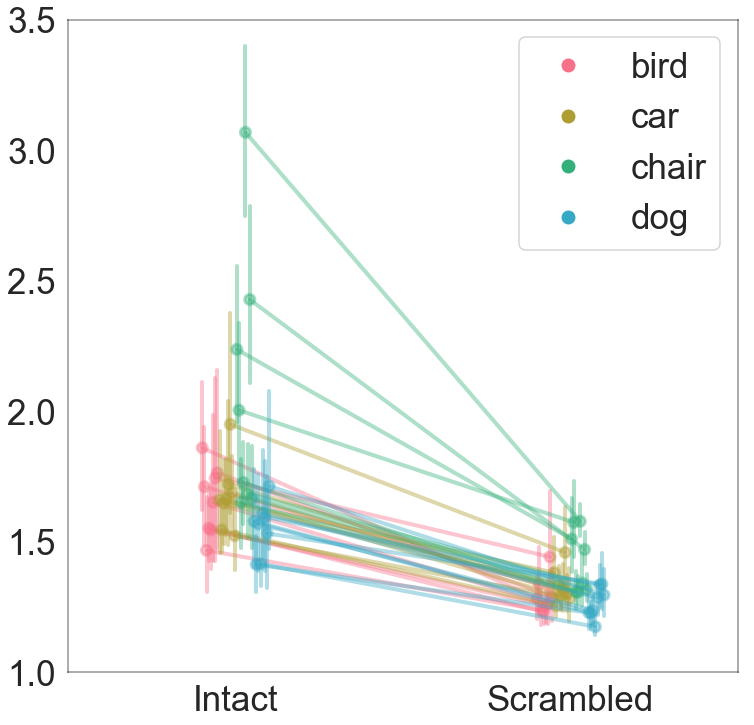

In [430]:
from matplotlib.lines import Line2D
palette= {
    'basset': C3, 'beetle': C1, 'bloodhound': C3, 'bluejay': C0,
    'bluesedan': C1, 'bluesport': C1, 'brown': C1, 'bullmastiff': C3,
    'chihuahua': C3, 'crow': C0, 'cuckoo': C0, 'doberman': C3,
    'goldenretriever': C3, 'hatchback': C1, 'inlay': C2, 'knob': C2,
    'leather': C2, 'nightingale': C0, 'pigeon': C0, 'pug': C3,
    'redantique': C1, 'redsport': C1, 'robin': C0, 'sling': C2,
    'sparrow': C0, 'squat': C2, 'straight': C2, 'tomtit': C0,
    'waiting': C2, 'weimaraner': C3, 'white': C1, 'woven': C2,
}


plt.figure(figsize=(12,12))

p = sns.pointplot(x="Condition", hue="objects", y= "Mean Streak Length",data=data,ci=95\
                  ,dodge= 0.2, palette = palette)
p.set(ylim=(1, 3.5))
plt.setp([p.get_children()[0],p.get_children()],alpha=0.4)

leg_elements = [Line2D([0], [0], marker='o', color='w', label='bird',
                          markerfacecolor=C0, markersize=15),
                Line2D([0], [0], marker='o', color='w', label='car',
                          markerfacecolor=C1, markersize=15),
                Line2D([0], [0], marker='o', color='w', label='chair',
                          markerfacecolor=C2, markersize=15),
                Line2D([0], [0], marker='o', color='w', label='dog',
                          markerfacecolor=C3, markersize=15),
               ]

plt.legend(handles= leg_elements, prop={'size': 35})
plt.tick_params(labelsize=35)
plt.xlabel('', fontsize=35)
plt.ylabel('', fontsize=35)
plt.savefig(os.path.join(plot_dir,'streak_length_pp'),edgecolor='w',bbox_inches='tight',dpi=500)




#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [504]:
def calculate_CI(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m.round(3), (m-h).round(3), (m+h).round(3)

(3.795, 1.761, 5.83)
(1.959, 1.166, 2.753)
(1.631, 0.76, 2.502)
(2.178, 1.242, 3.114)
(1.776, 1.213, 2.34)
(2.212, 1.261, 3.163)
(1.217, 0.362, 2.072)
(2.703, 0.776, 4.629)
(0.944, 0.549, 1.339)
(2.021, 1.177, 2.865)
(1.251, 0.724, 1.778)
(2.185, 1.317, 3.054)
(2.126, 0.9, 3.352)
(2.13, 1.19, 3.069)
(1.934, 1.251, 2.618)
(1.44, 0.837, 2.043)
(3.206, 2.093, 4.318)
(1.679, 1.044, 2.313)
(1.552, 0.857, 2.247)
(2.084, 1.248, 2.92)
(4.801, 3.691, 5.912)
(1.546, 0.902, 2.191)
(3.253, 2.087, 4.419)
(1.586, 0.683, 2.488)
(2.255, 1.09, 3.421)
(1.3, 0.655, 1.945)
(2.109, 0.781, 3.438)
(1.813, 1.201, 2.424)
(1.857, 0.971, 2.742)
(1.325, 0.337, 2.313)
(1.247, -0.074, 2.568)
(2.226, 1.262, 3.19)


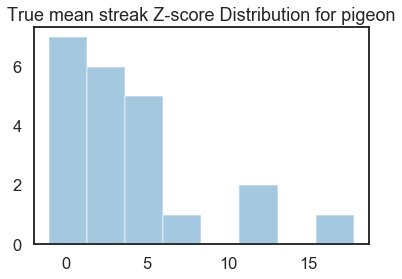

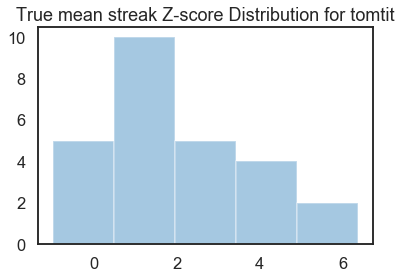

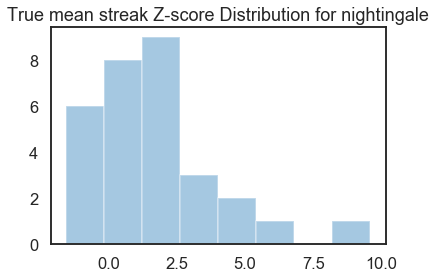

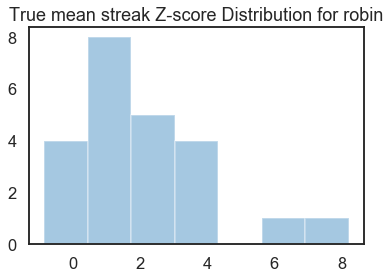

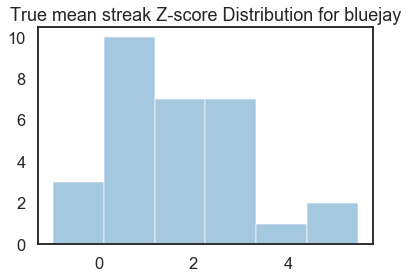

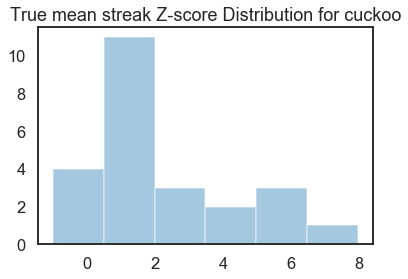

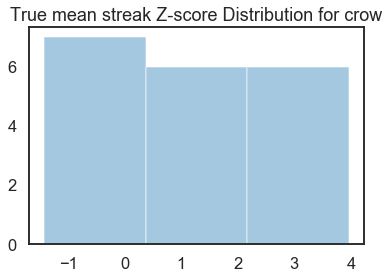

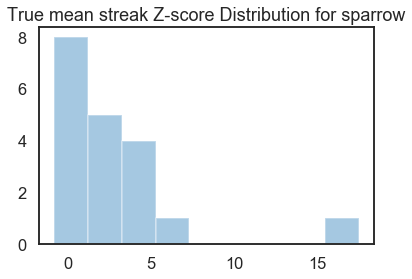

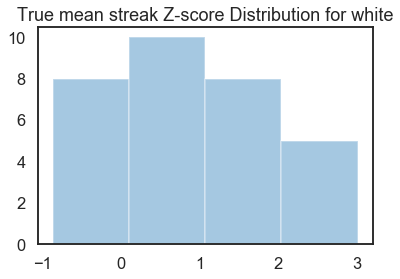

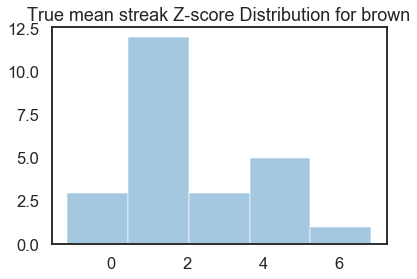

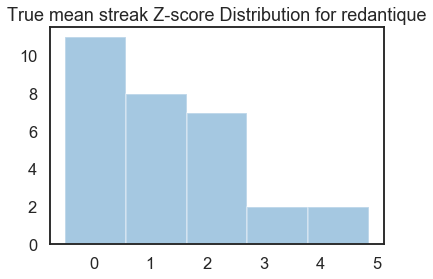

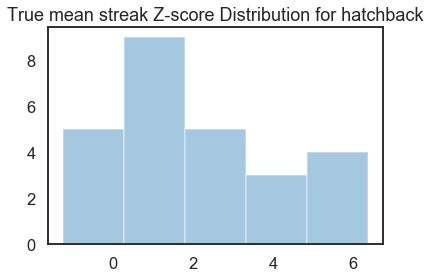

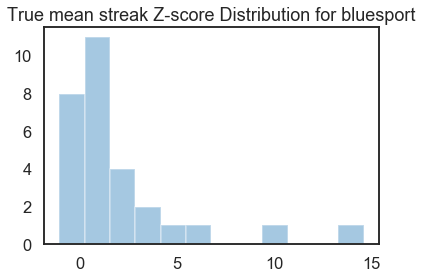

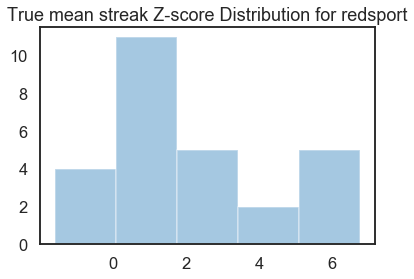

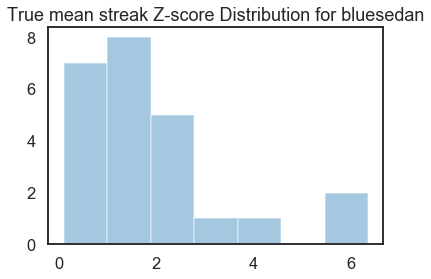

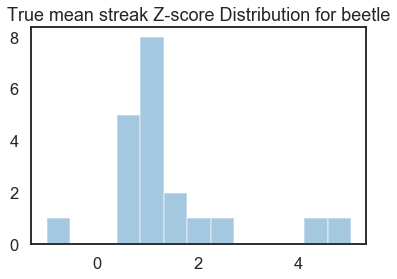

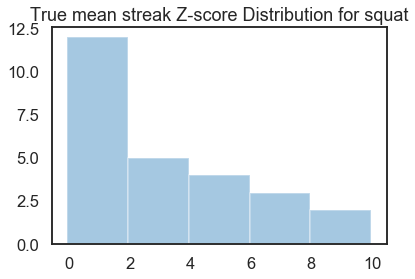

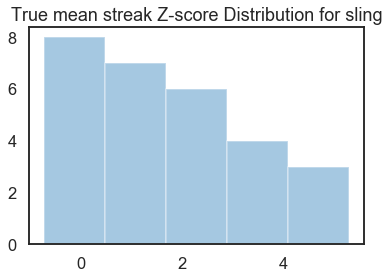

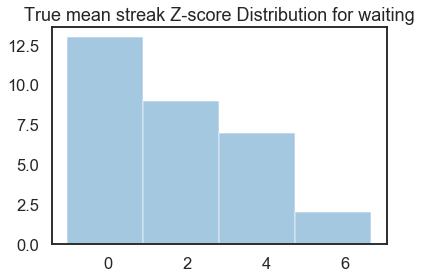

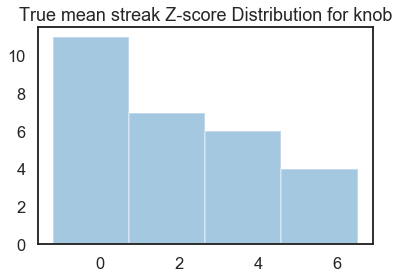

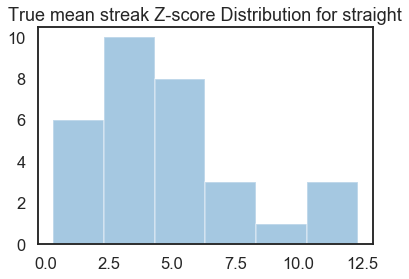

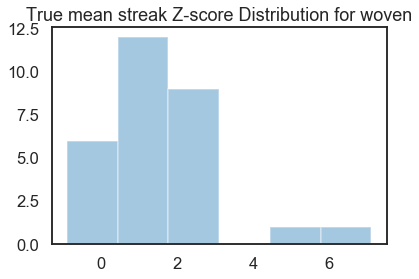

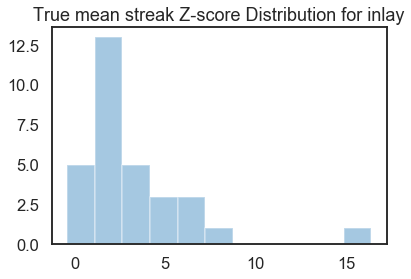

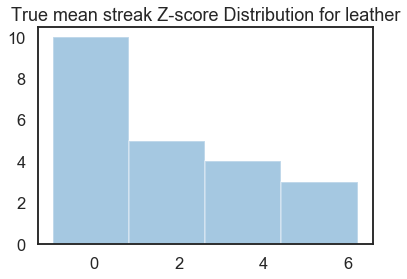

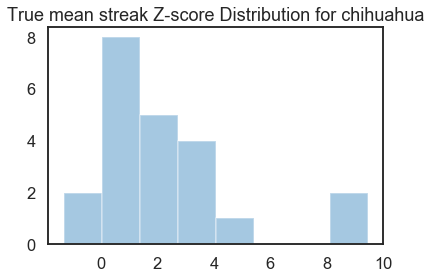

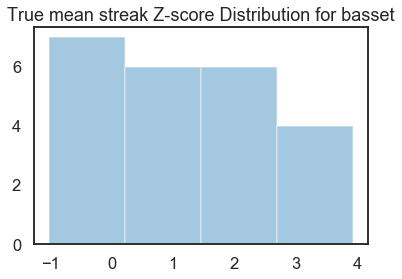

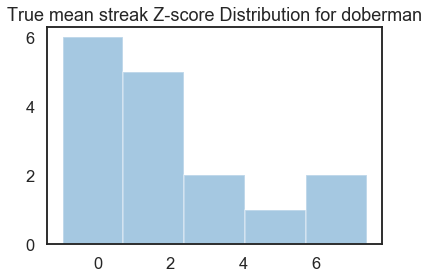

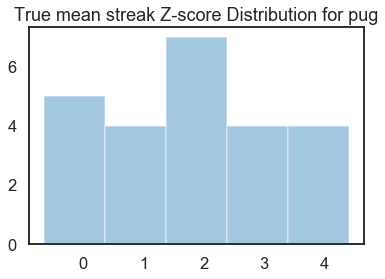

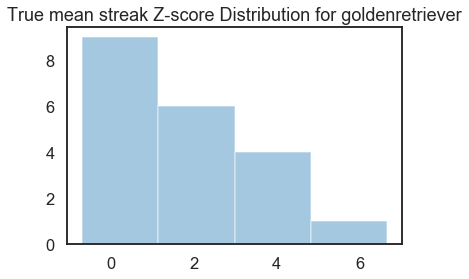

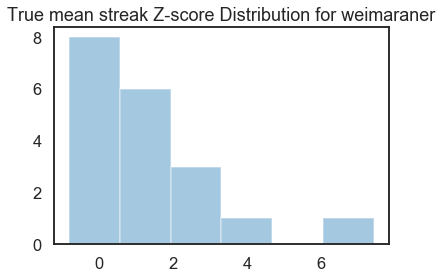

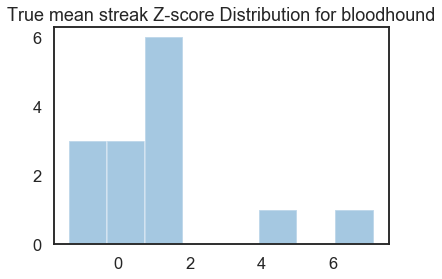

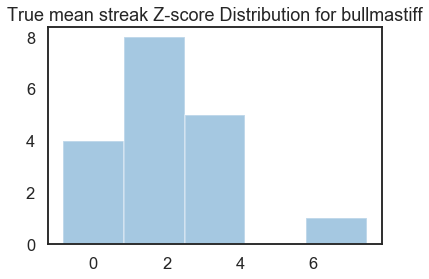

In [505]:
for this_target in stroke_df.target.unique():
    DA=stroke_df[stroke_df['target']==this_target]
    _sketch_ids = DA.sketch_id.unique()
    _sketch_ids = [x for x in _sketch_ids if x not in donotpermute]
    z_scores_sub=dict((k, gt_streak_zscore[k]) for k in _sketch_ids)
    plt.figure()
    plt.title('True mean streak Z-score Distribution for {}'.format(this_target))
    h=sns.distplot(z_scores_sub.values(),kde=False,hist=True,norm_hist=False)
    print calculate_CI(z_scores_sub.values())
    
   

In [506]:
streak_diff_dict={}
for this_cat in unique_cats:
    mean_streak_diff_list=[]
    DS=stroke_df[stroke_df['category']==this_cat]
    for i in range(1000):
        scrambled_streaks=[] 
        real_streaks=[]
        for sketch in np.unique(DS['sketch_id']):
            scrambled_streaks.append(get_scramble_mean_streak(sketch))
            real_streaks.append(get_mean_streak(sketch))
        mean_streak_diff_list.append(np.mean(real_streaks)-np.mean(scrambled_streaks))
    streak_diff_dict[this_cat]=mean_streak_diff_list

 mean and CI for (2.066, 1.897, 2.234)


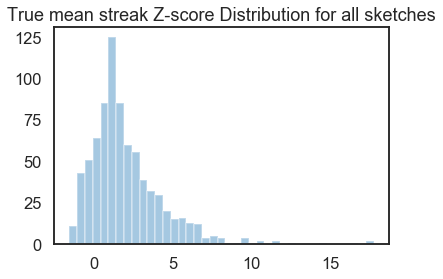

In [508]:

DA=D
_sketch_ids= DA.sketch_id.unique()
_sketch_ids = [x for x in _sketch_ids if x not in donotpermute]
z_scores_sub=dict((k, gt_streak_zscore[k]) for k in _sketch_ids)
plt.figure()
plt.title('True mean streak Z-score Distribution for all sketches')
h=sns.distplot(z_scores_sub.values(),kde=False,hist=True,norm_hist=False)
print 'mean and CI for', calculate_CI(z_scores_sub.values())

mean and CI for closer condition (2.5871549128948157, 2.295371950741054, 2.8789378750485772)
mean and CI for further condition (1.613654042110611, 1.4366599668666133, 1.7906481173546085)


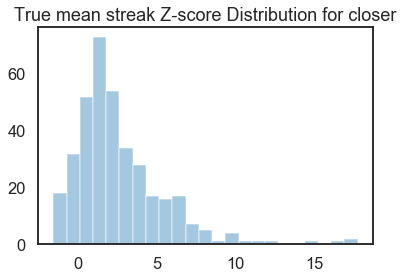

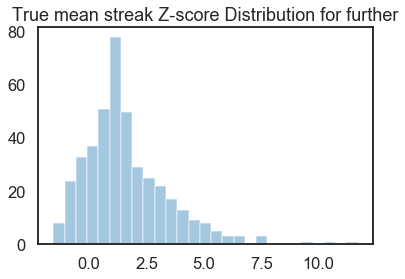

In [499]:
##broken out by condition
for this_cond in stroke_df.condition.unique():
    DA=stroke_df[stroke_df['condition']==this_cond]
    _sketch_ids= DA.sketch_id.unique()
    _sketch_ids = [x for x in _sketch_ids if x not in donotpermute]
    z_scores_sub=dict((k, gt_streak_zscore[k]) for k in _sketch_ids)
    plt.figure()
    plt.title('True mean streak Z-score Distribution for {}'.format(this_cond))
    h=sns.distplot(z_scores_sub.values(),kde=False,hist=True,norm_hist=False)
    print 'mean and CI for {} condition'.format(this_cond), calculate_CI(z_scores_sub.values())

In [57]:
def CIPlot(category): 
    stroke_df_lite_ss=stroke_df[stroke_df['category']==category]
    mean_streak_diff_list=[]
    for i in range(1000):
        this_round_scrambled_streak=[] 
        this_round_real_streak=[]
        for sketch in np.unique(stroke_df_lite_ss['sketch_id']):
            this_round_real_streak.append(get_mean_streak(sketch))
            this_round_scrambled_streak.append(get_scramble_mean_streak(sketch))
        mean_streak_diff_list.append(np.mean(this_round_real_streak)-np.mean(this_round_scrambled_streak))
    perm_observed_mean_streak_diff = np.mean(mean_streak_diff_list)    
    lb=np.percentile(mean_streak_diff_list,2.5)
    ub=np.percentile(mean_streak_diff_list,97.5)
    plt.figure(figsize=(10,8))
    h=sns.distplot(mean_streak_diff_list,kde=False,hist=True,norm_hist=False)
    plt.axvline(perm_observed_mean_streak_diff, color='yellow', linestyle='solid', linewidth=2)
    plt.axvline(lb, color='orange', linestyle='solid', linewidth=2)
    plt.axvline(ub, color='orange', linestyle='solid', linewidth=2)
    plt.title(category)
    plt.ylabel('count')
    plt.xlabel('streak length difference')
    plt.legend(['mean','95% CI'], ncol=2, bbox_to_anchor=(1, 1.05))
    
    plt.savefig(os.path.join(plot_dir,'Streakiness Diff'),edgecolor='w',bbox_inches='tight')
    plt.show()
    return np.mean(mean_streak_diff_list), np.std(mean_streak_diff_list)




def CIPlotCatCond(category,condition): 
    stroke_df_lite_ss=stroke_df[(stroke_df['category']==category)&(stroke_df['condition']==condition)]
    mean_streak_diff_list=[]
    for i in range(1000):
        this_round_scrambled_streak=[] 
        this_round_real_streak=[]
        for sketch in np.unique(stroke_df_lite_ss['sketch_id']):
            this_round_real_streak.append(get_mean_streak(sketch))
            this_round_scrambled_streak.append(get_scramble_mean_streak(sketch))
        mean_streak_diff_list.append(np.mean(this_round_real_streak)-np.mean(this_round_scrambled_streak))
    perm_observed_mean_streak_diff = np.mean(mean_streak_diff_list)    
    lb=np.percentile(mean_streak_diff_list,2.5)
    ub=np.percentile(mean_streak_diff_list,97.5)
    plt.figure(figsize=(10,8))
    h=sns.distplot(mean_streak_diff_list,kde=False,hist=True,norm_hist=False)
    plt.axvline(perm_observed_mean_streak_diff, color='yellow', linestyle='solid', linewidth=2)
    plt.axvline(lb, color='orange', linestyle='solid', linewidth=2)
    plt.axvline(ub, color='orange', linestyle='solid', linewidth=2)
    plt.title('{}_{}'.format(category,condition))
    plt.ylabel('count')
    plt.xlabel('streak length difference')
    plt.legend(['mean','95% CI'], ncol=2, bbox_to_anchor=(1, 1.05))
    
    plt.savefig(os.path.join(plot_dir,'mean_streak_difference_{}_{}'.format(category, condition)),edgecolor='w',bbox_inches='tight')
    plt.show()
    return perm_observed_mean_streak_diff, lb, ub
    

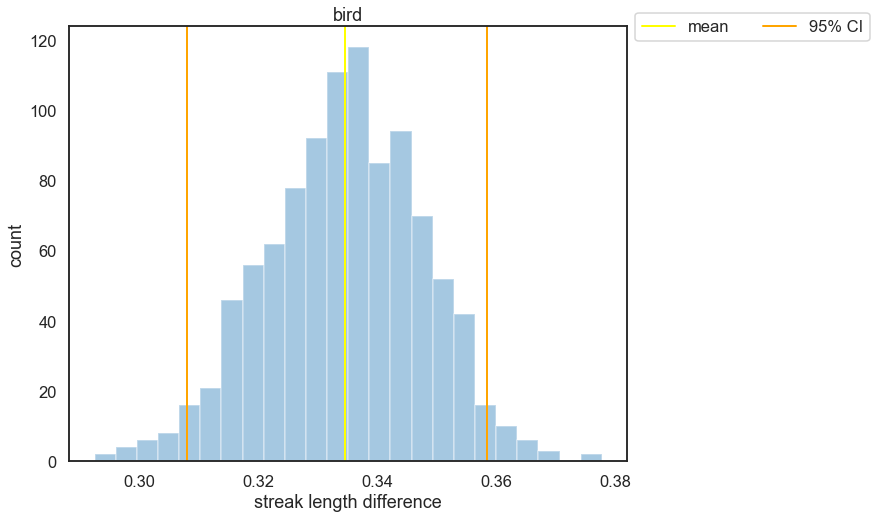

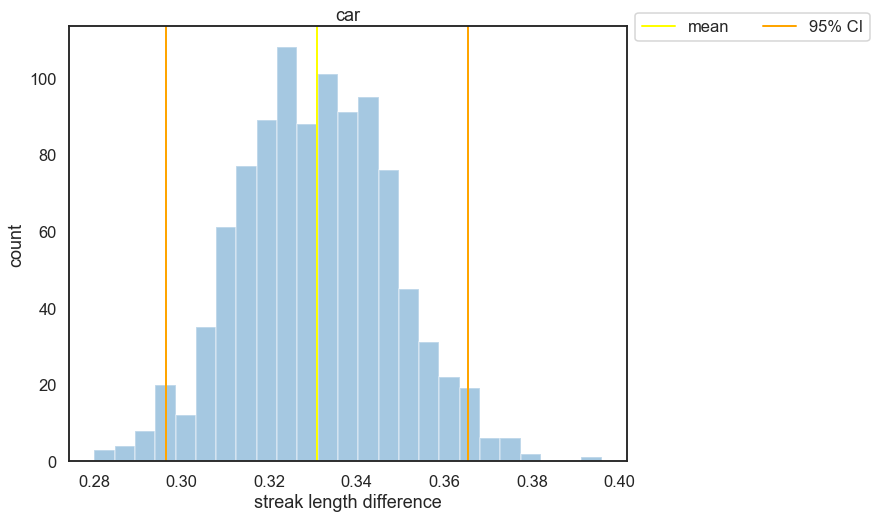

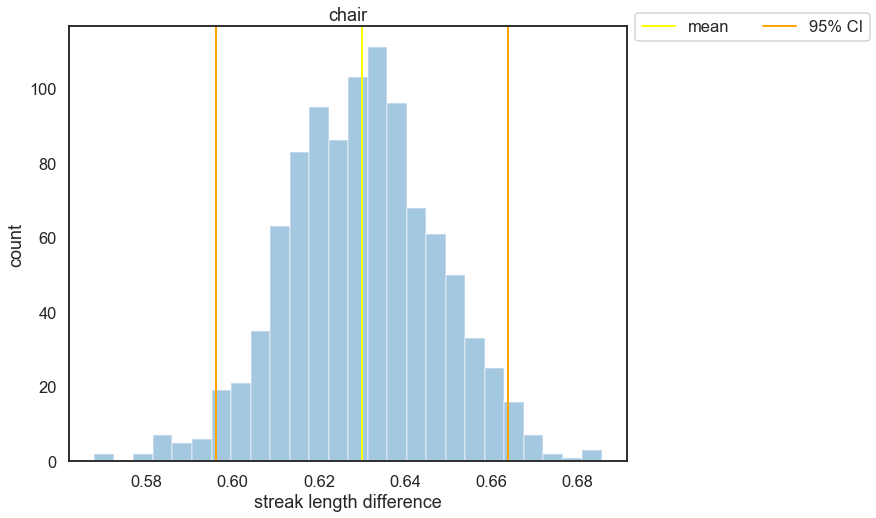

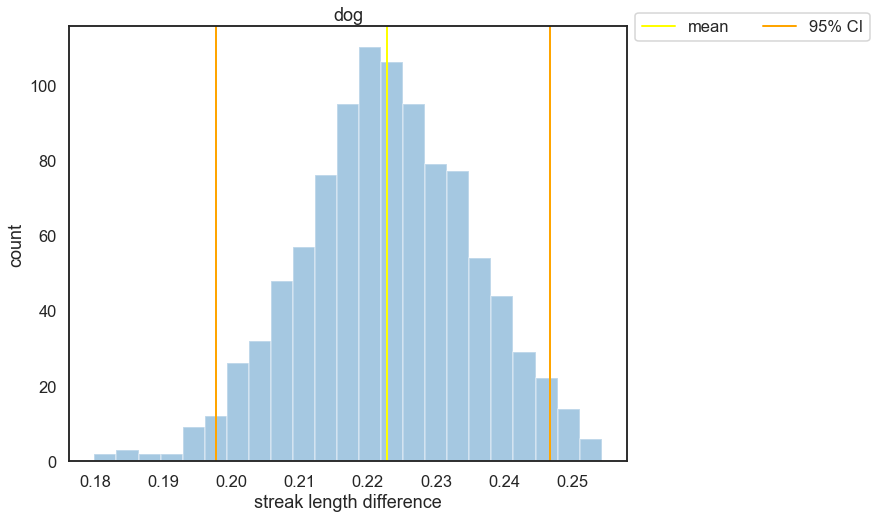

In [58]:
for this_cat in unique_cats:
    CIPlot(this_cat)

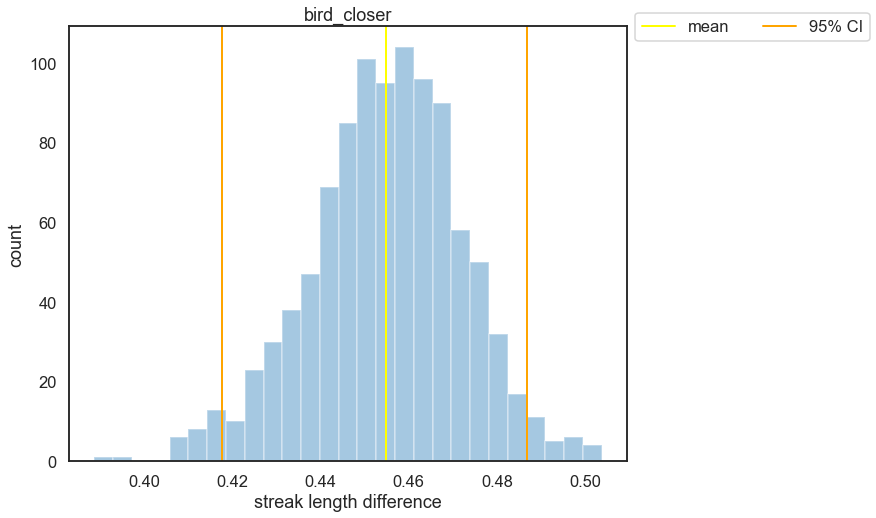

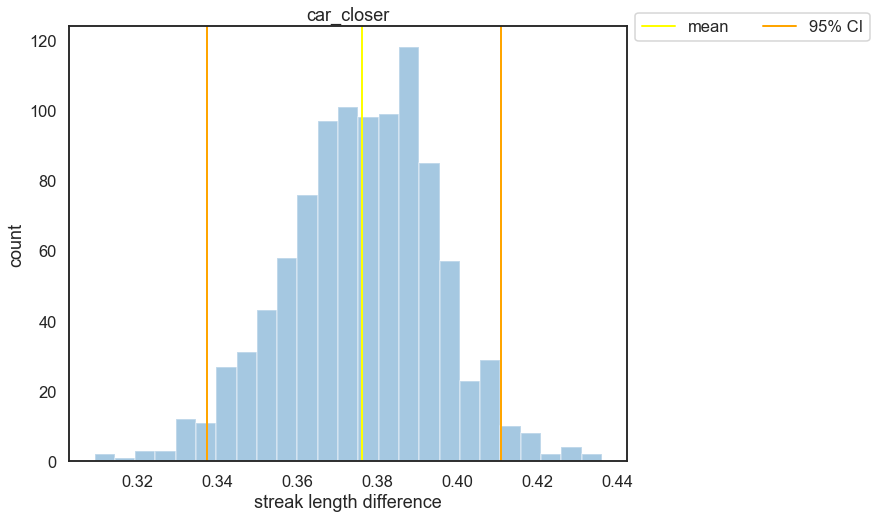

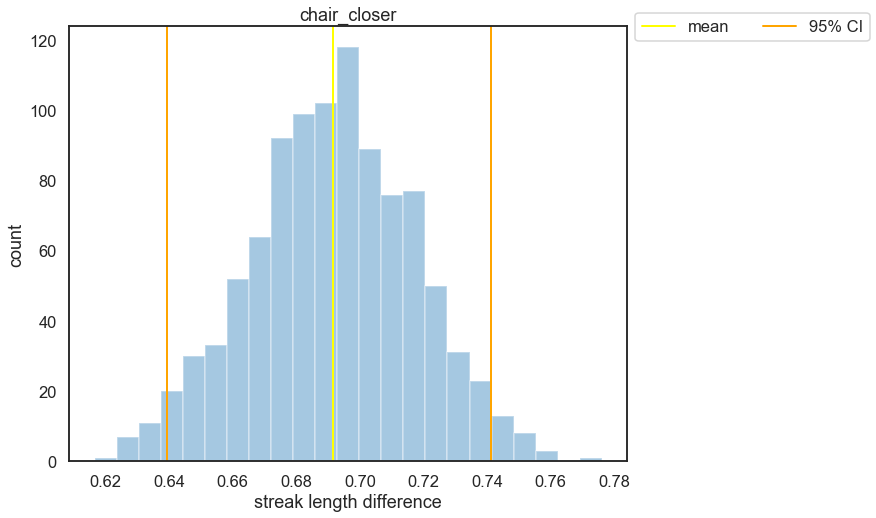

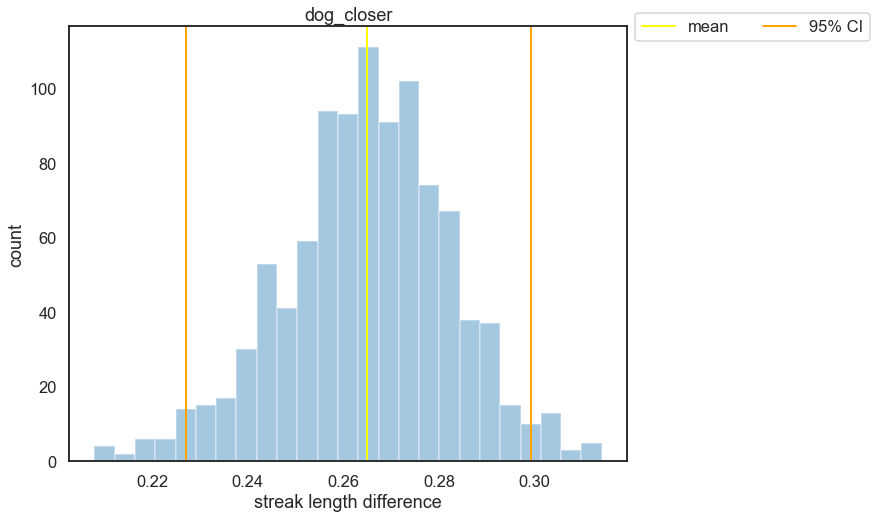

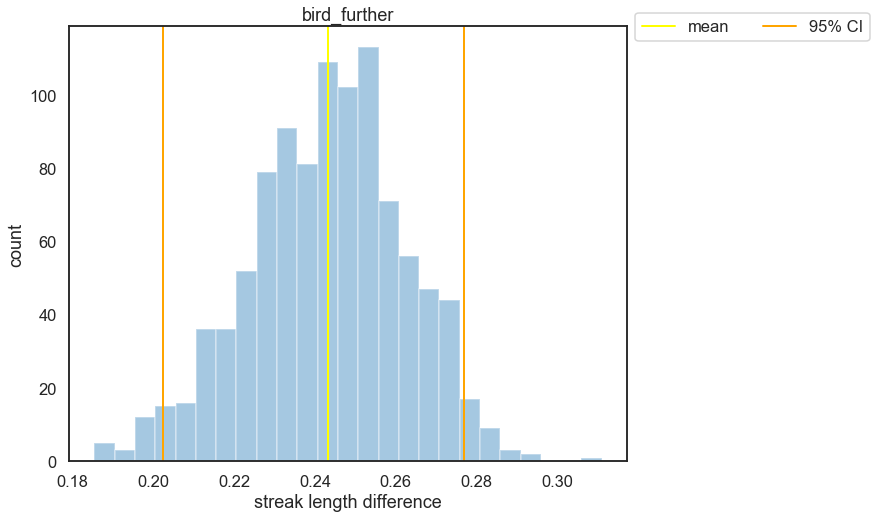

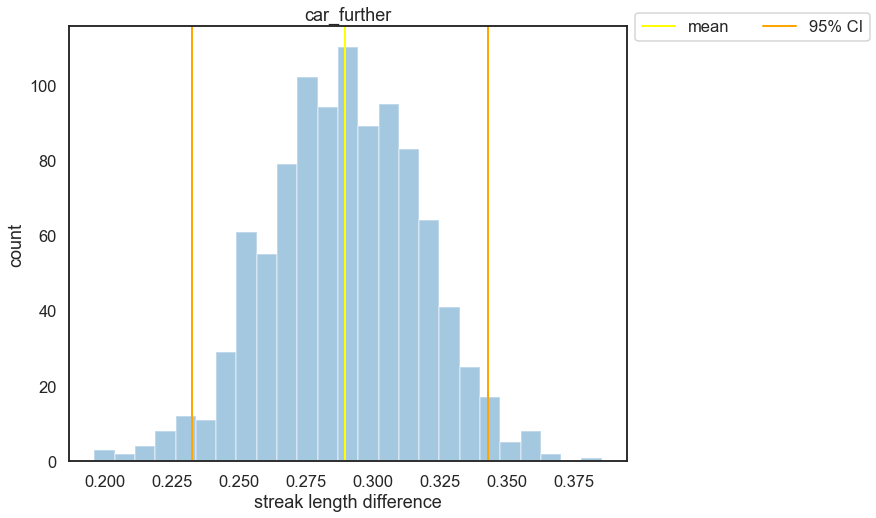

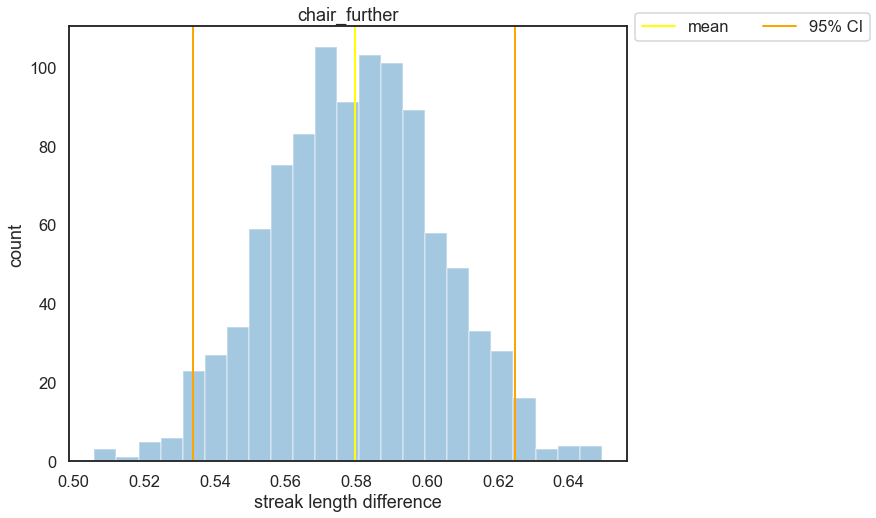

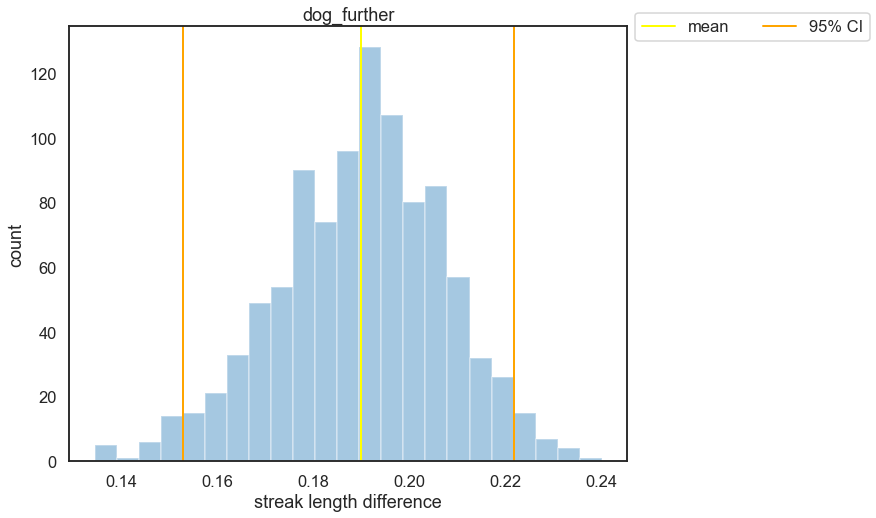

In [59]:
for this_condition in np.unique(stroke_df['condition']):
    for this_category in np.unique(stroke_df['category']):
        CIPlotCatCond(this_category, this_condition)

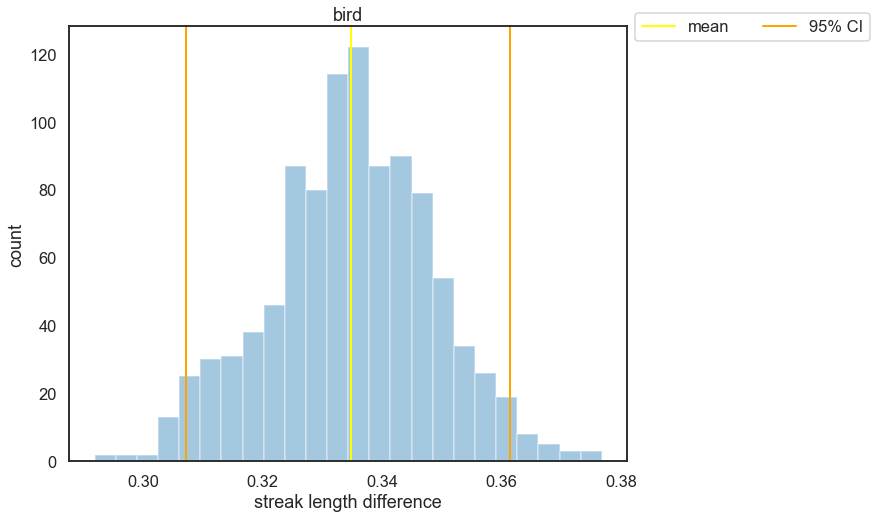

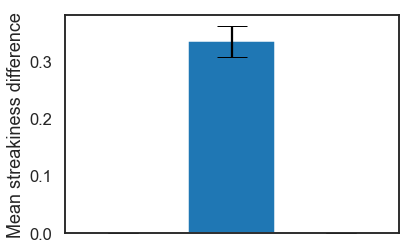

(0.33488174705994767, 0.013734139601962696)


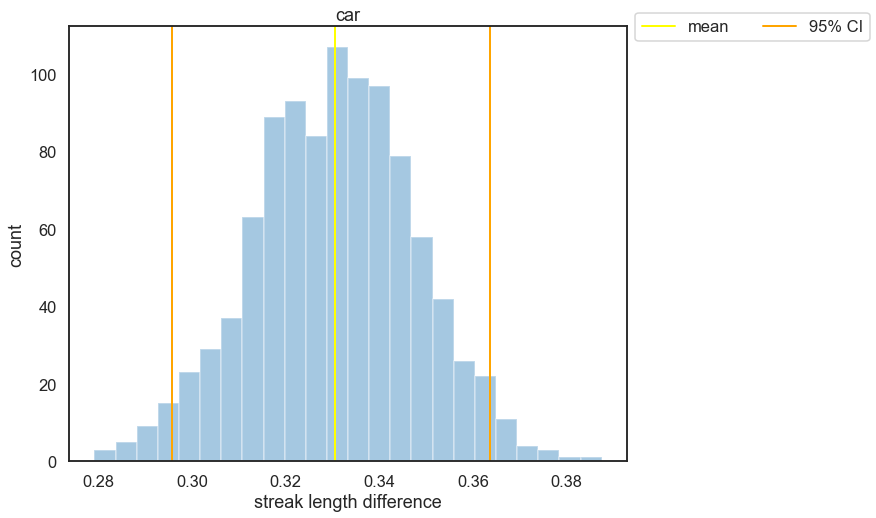

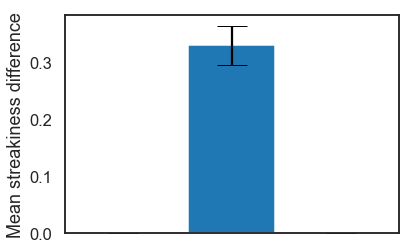

(0.33048006589405576, 0.017323678746333098)


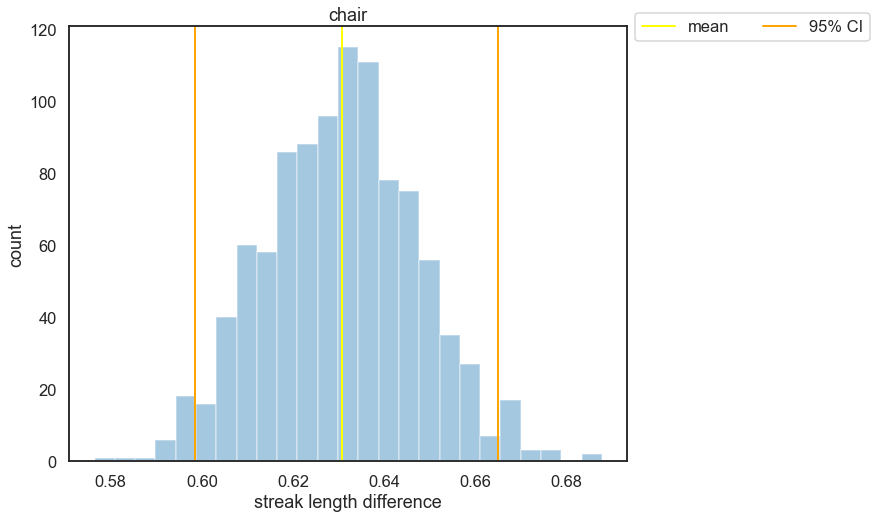

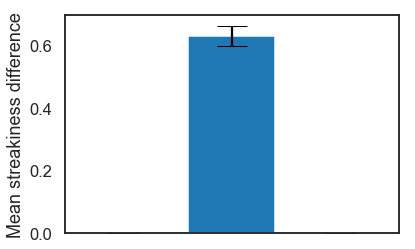

(0.6307062064589394, 0.01655202154137263)


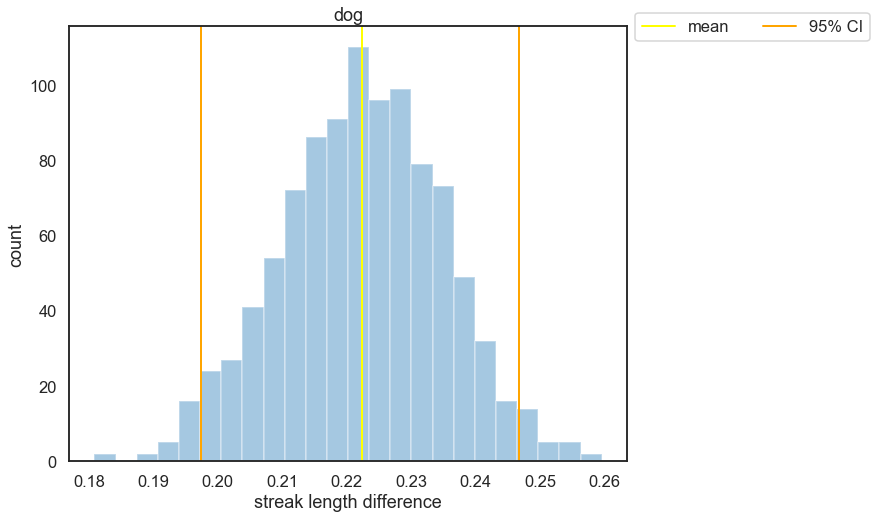

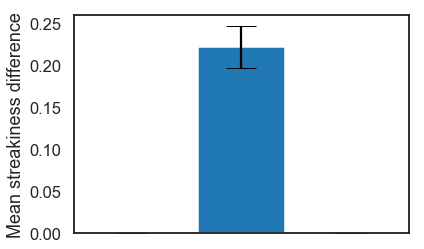

(0.22240533249509373, 0.012509942199569371)


In [60]:
for this_cat in unique_cats:
    plot_data= CIPlot(this_cat)
    plt.figure
    CI_data= np.array(plot_data[0]-plot_data[0]-2*plot_data[1], plot_data[0]-plot_data[0]+2*plot_data[1])
    h= plt.bar([0,1,2],[0,plot_data[0],0],yerr=[0,CI_data,0],capsize=15)
    plt.xlabel('')
    plt.ylabel('Mean streakiness difference')
    plt.xticks([0,1,2],['','',''])
    plt.savefig(os.path.join(plot_dir,'{}_streak_diff'.format(this_cat)),edgecolor='w',bbox_inches='tight')
    plt.show()
    print plot_data

In [61]:
def plot_CM(df_confusion, title='Confusion matrix', cmap=plt.cm.Spectral):
    plt.matshow(df_confusion, cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)




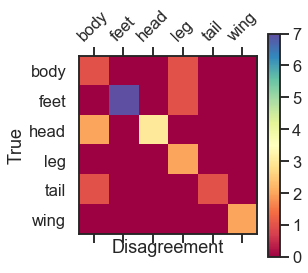

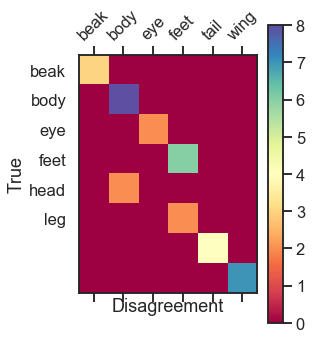

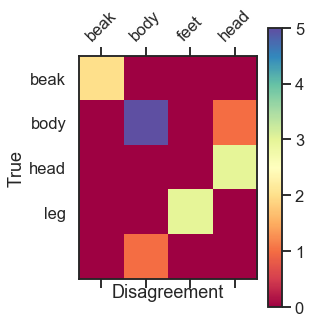

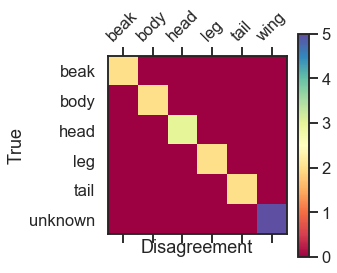

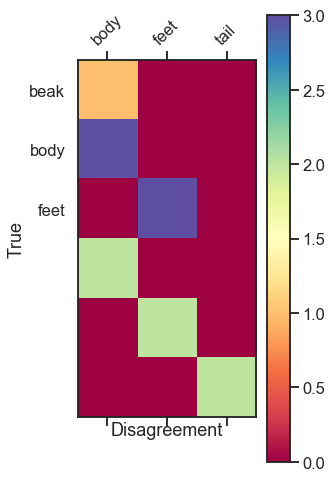

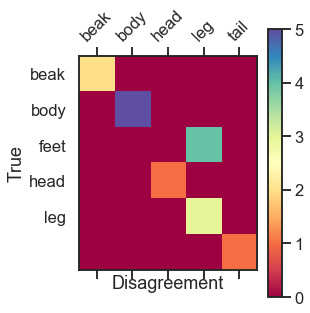

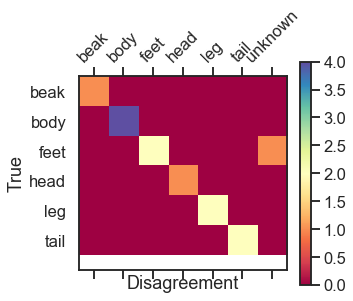

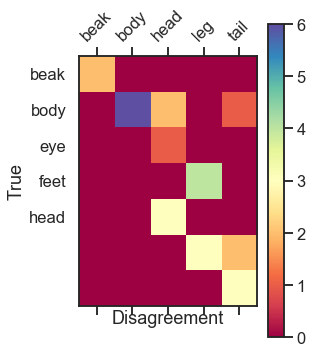

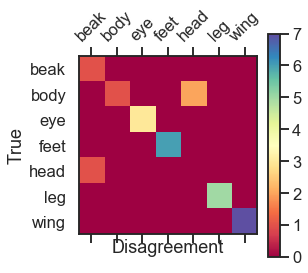

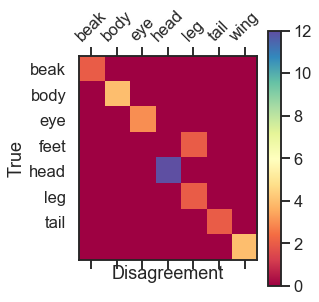

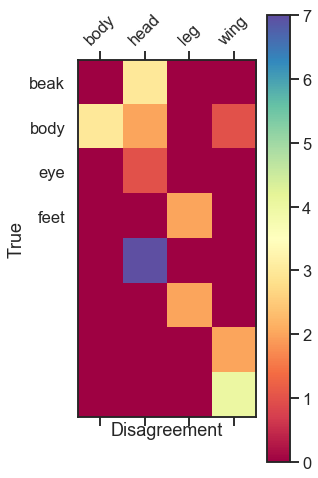

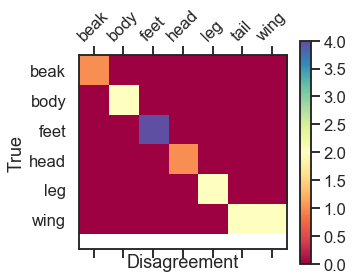

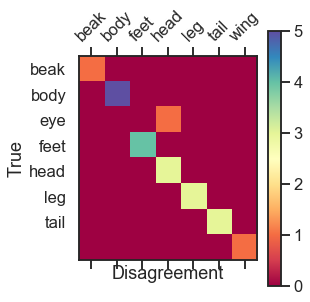

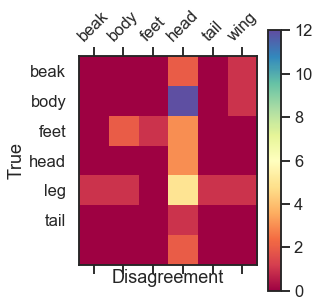

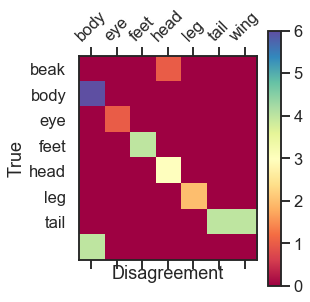

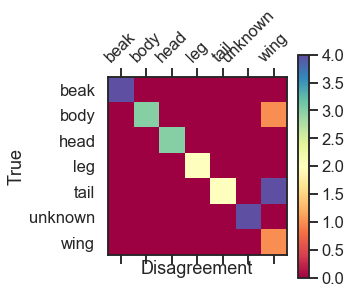

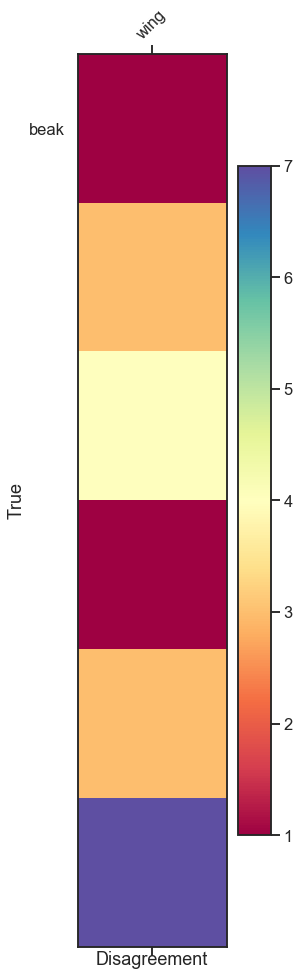

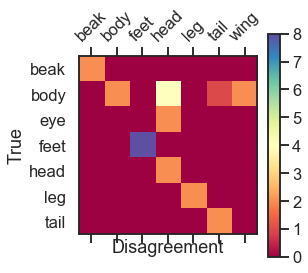

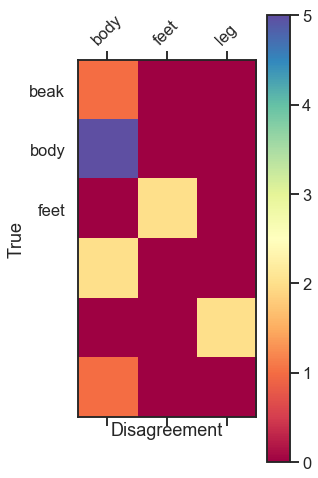

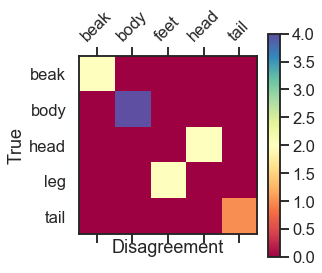

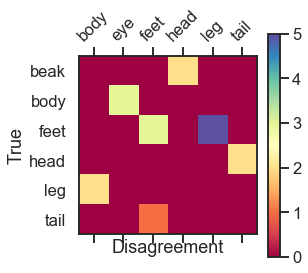

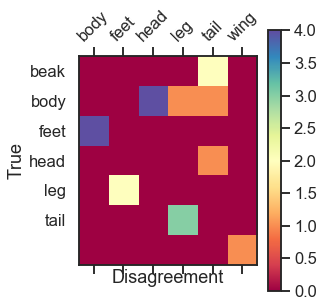

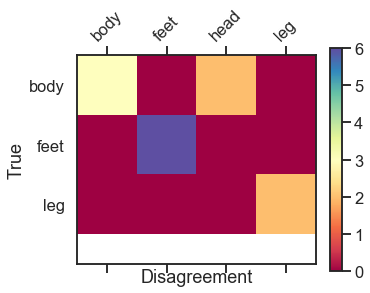

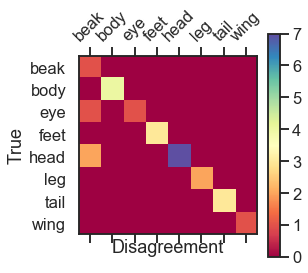

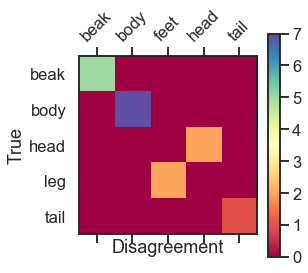

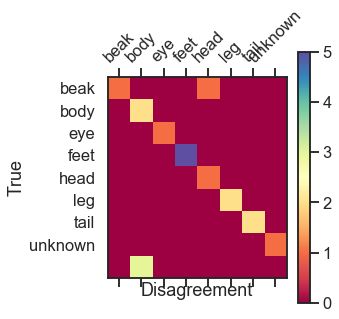

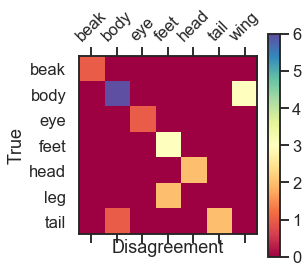

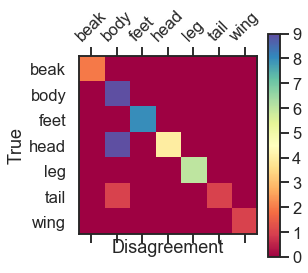

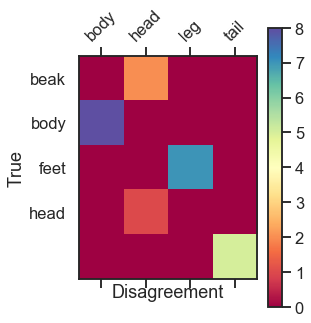

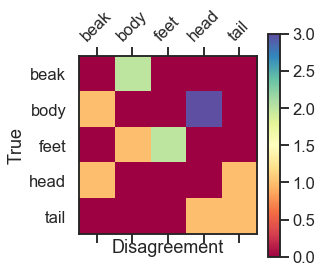

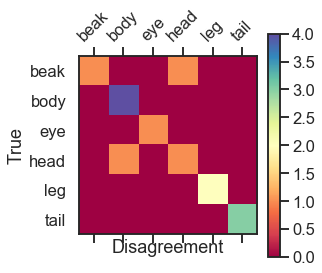

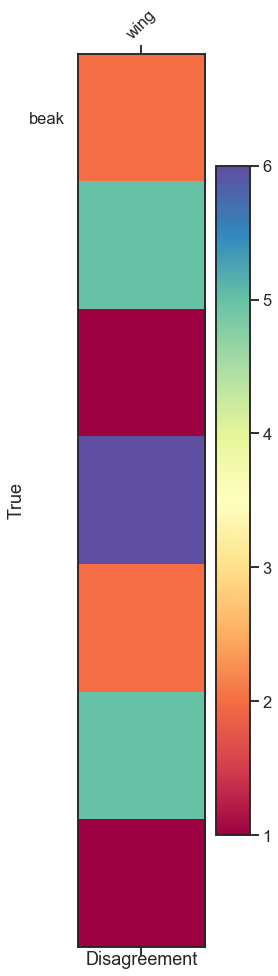

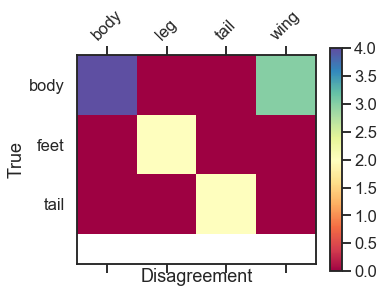

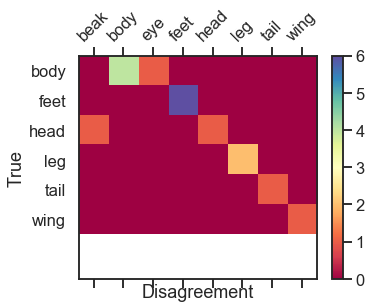

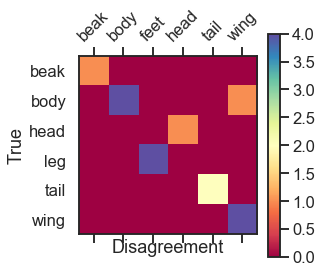

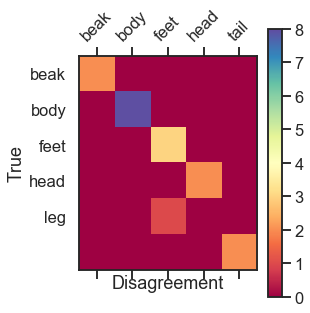

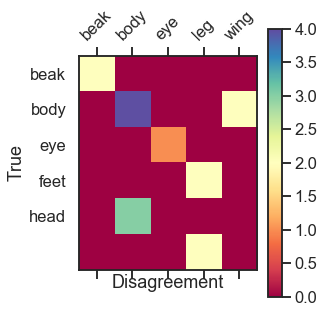

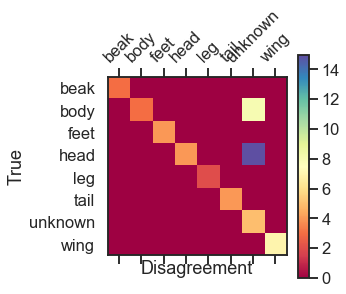

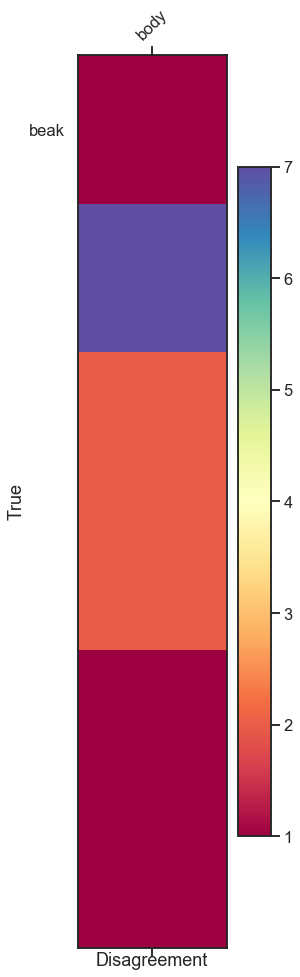

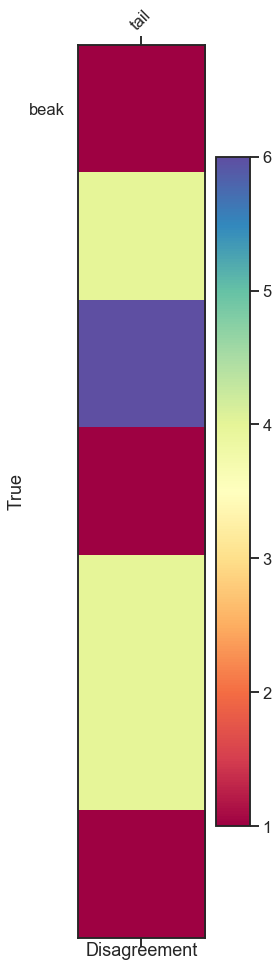

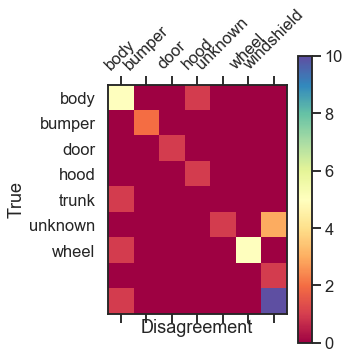

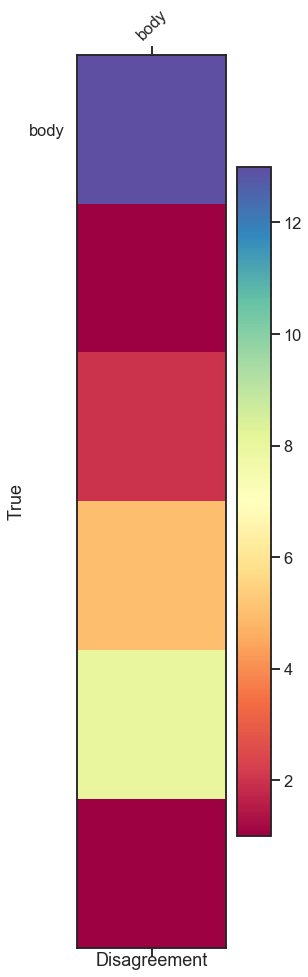

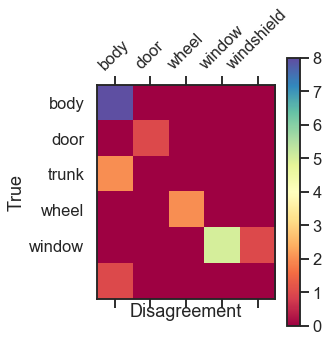

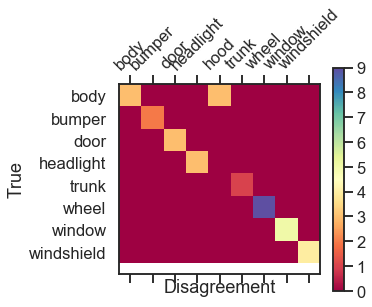

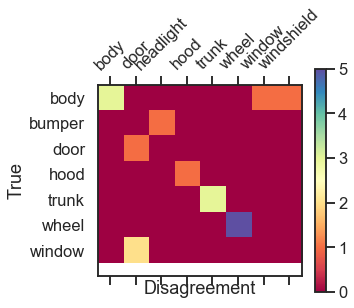

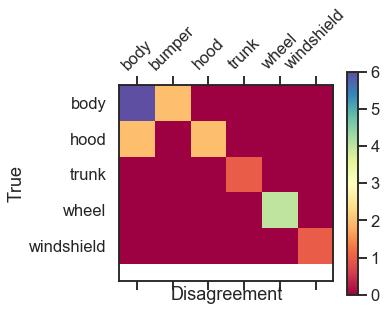

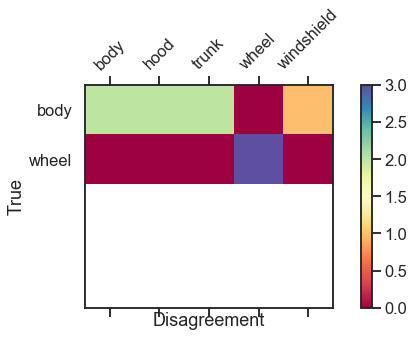

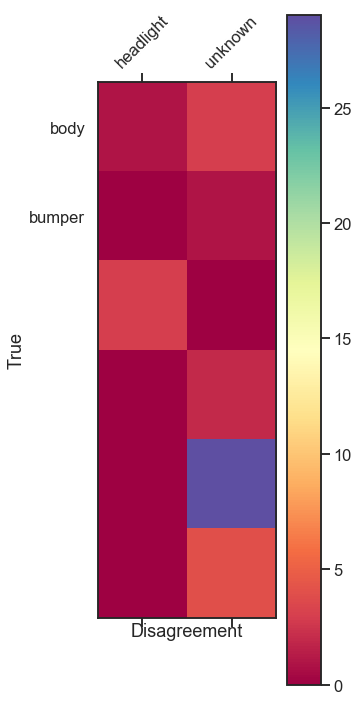

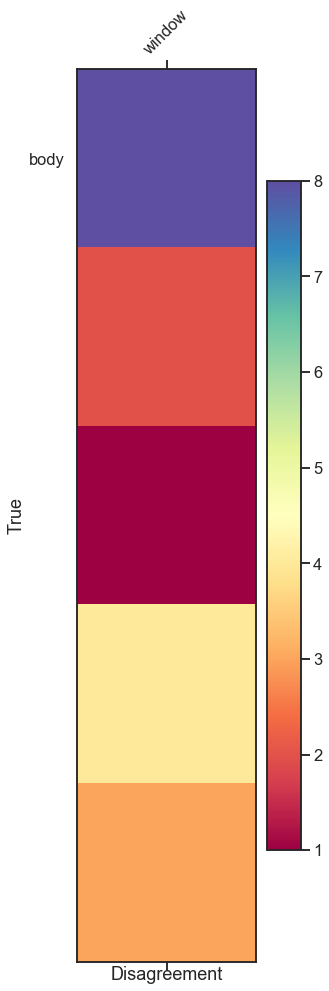

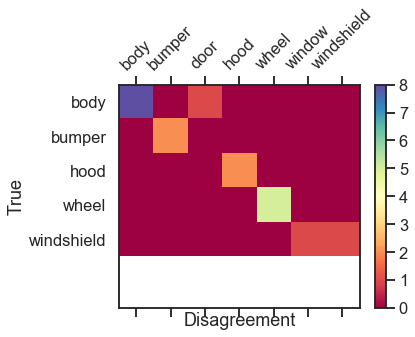

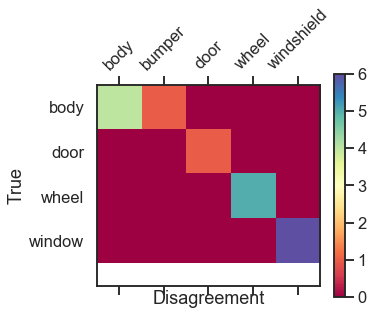

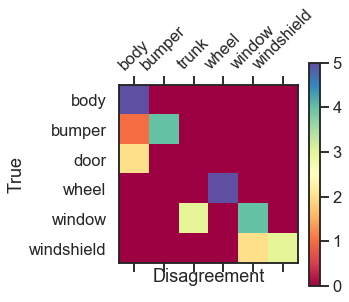

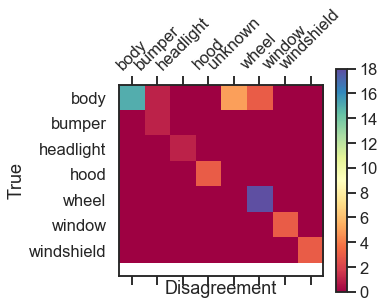

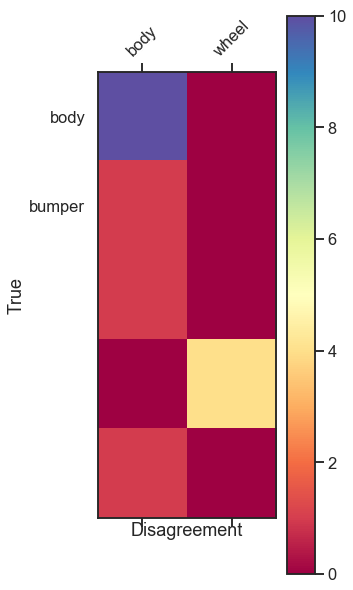

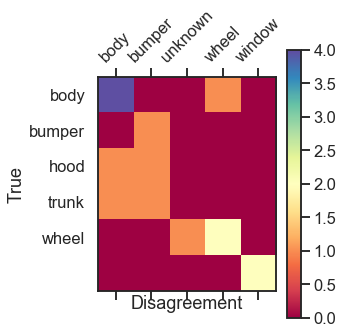

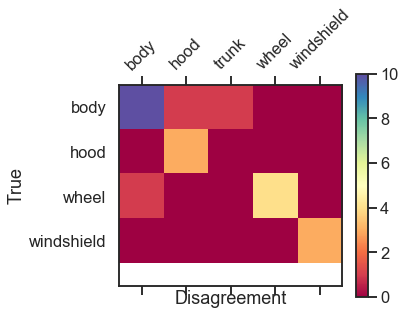

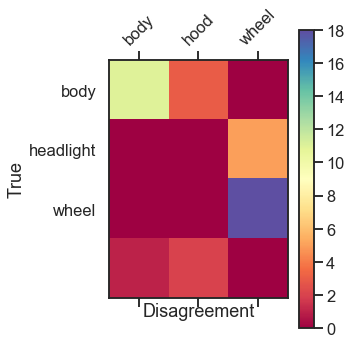

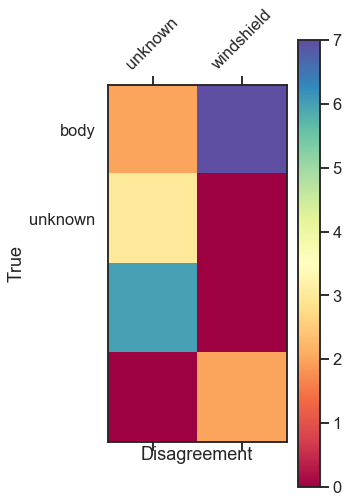

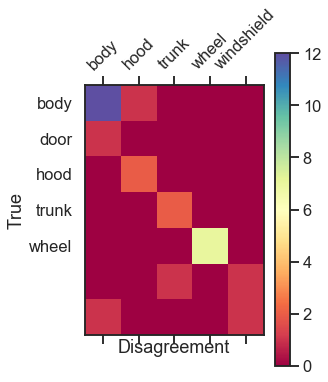

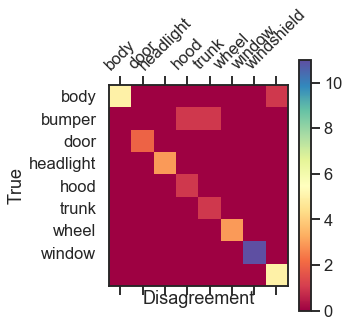

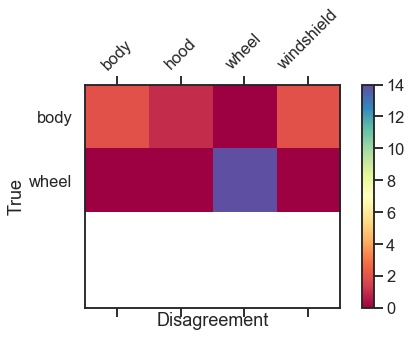

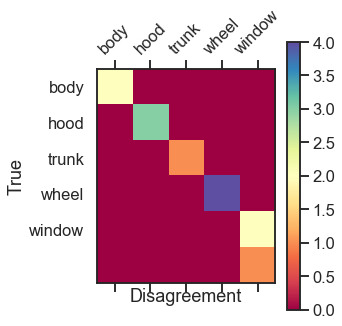

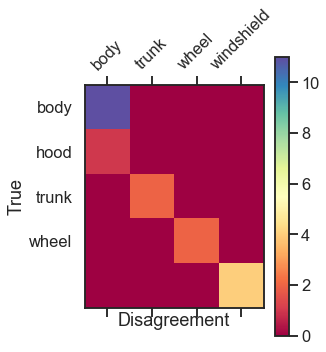

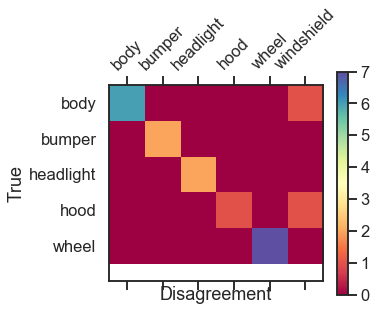

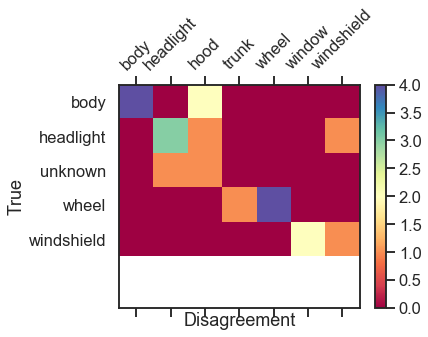

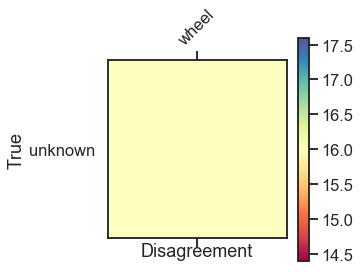

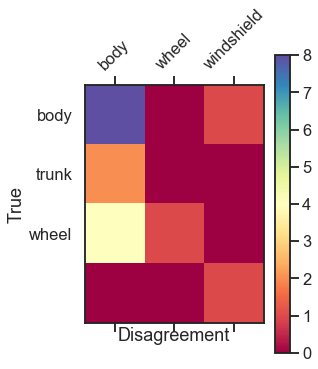

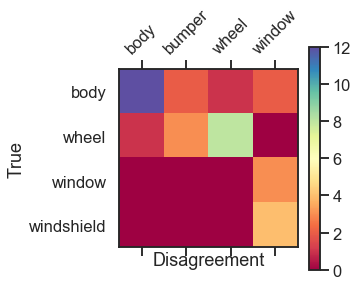

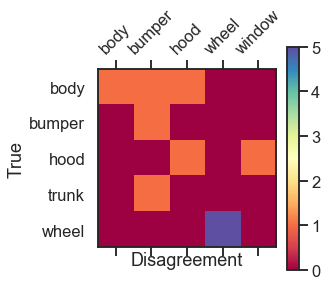

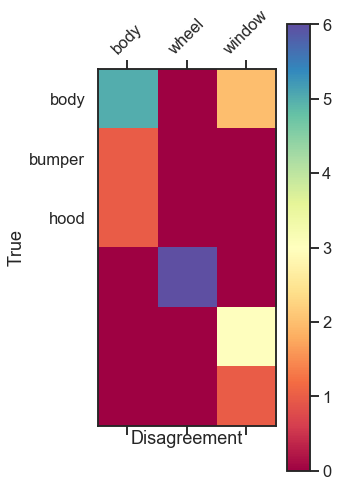

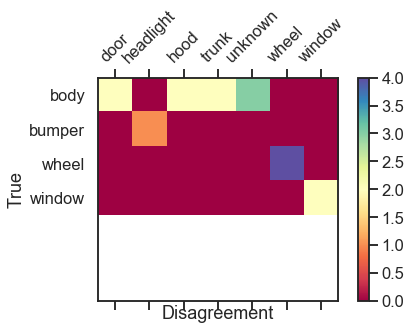

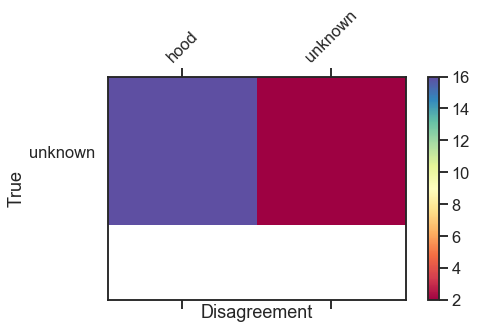

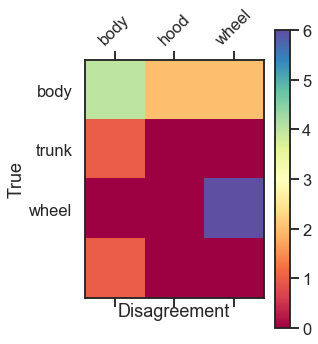

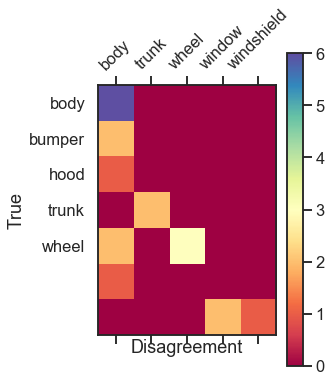

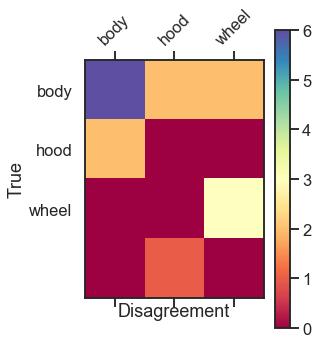

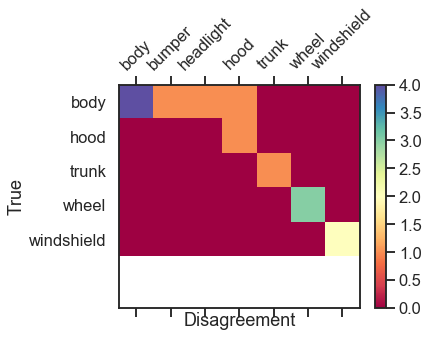

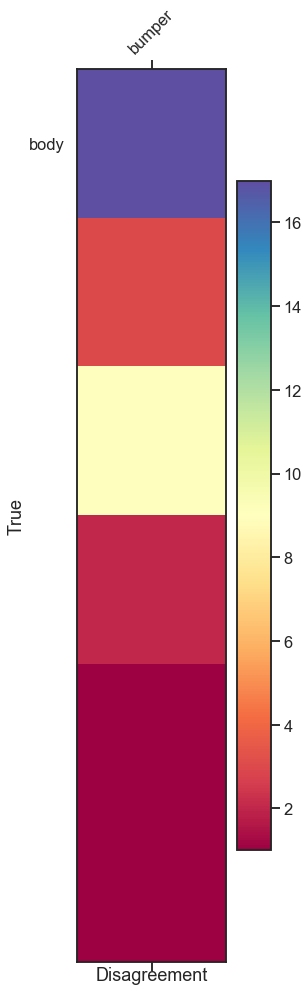

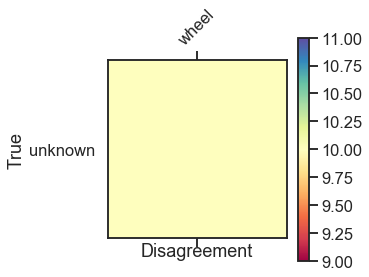

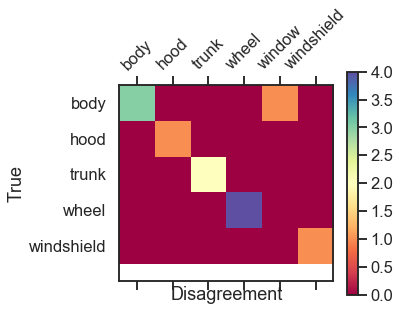

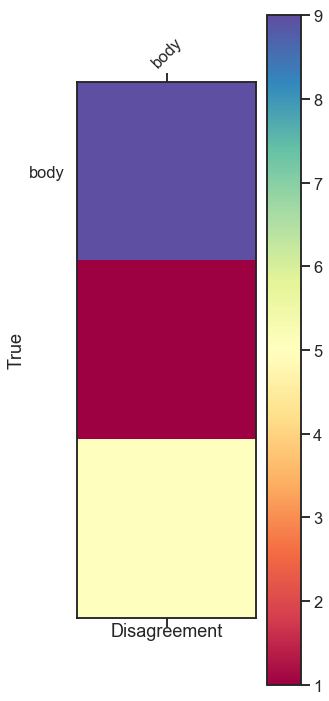

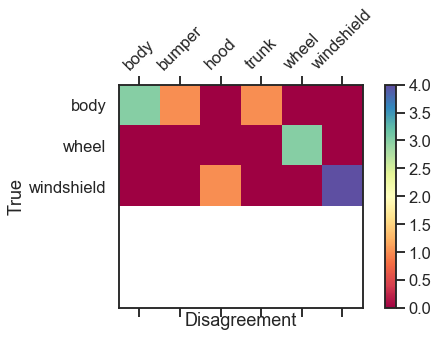

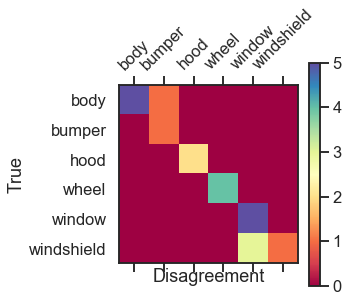

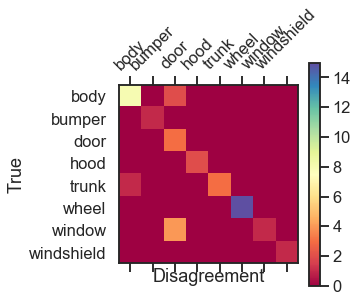

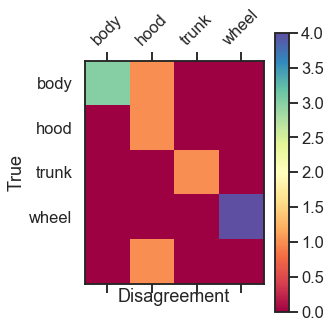

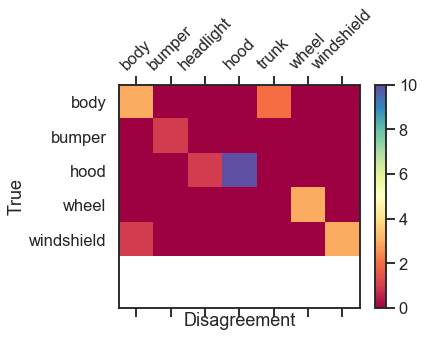

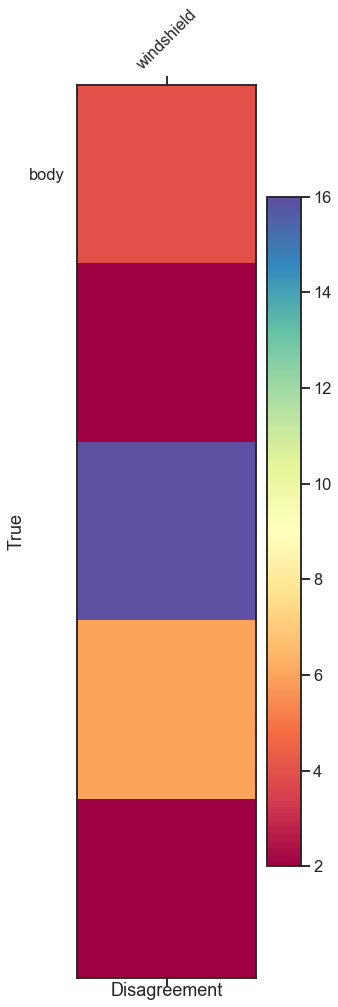

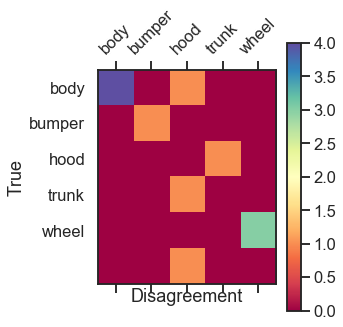

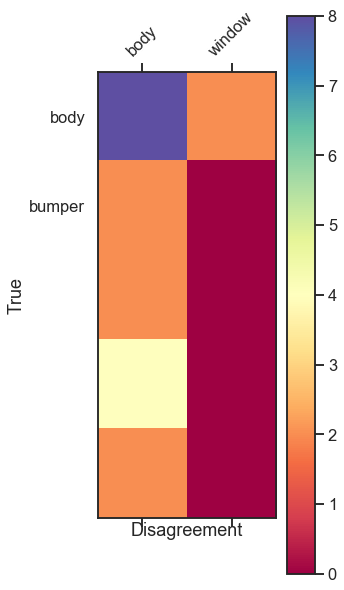

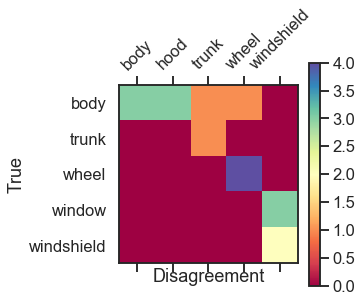

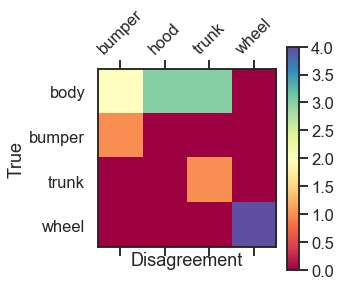

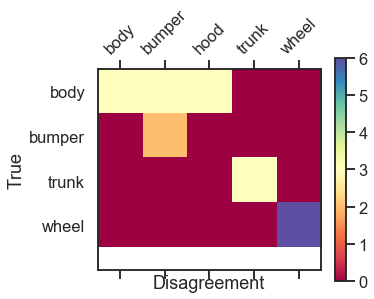

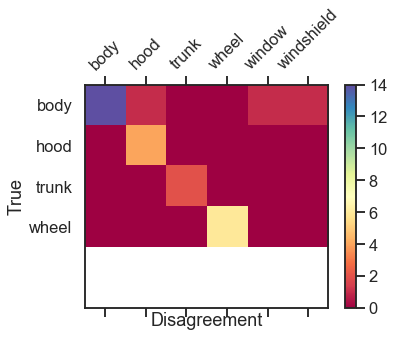

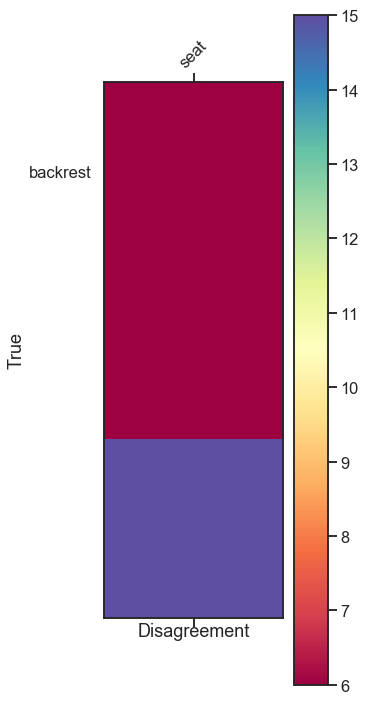

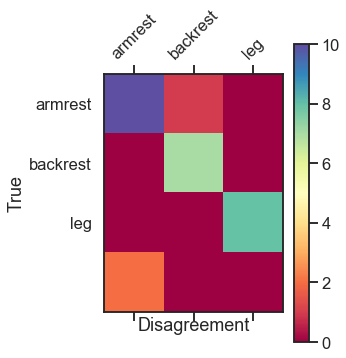

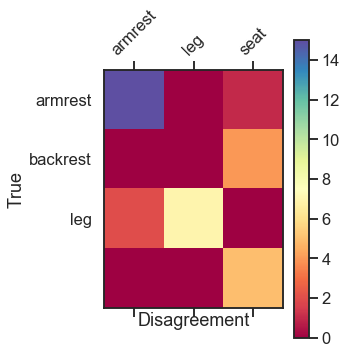

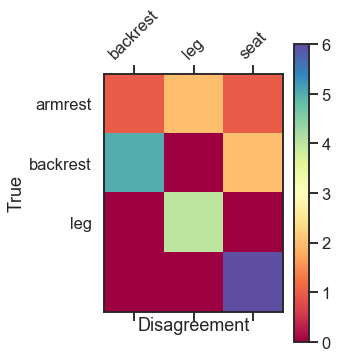

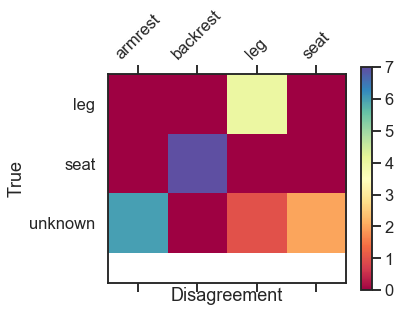

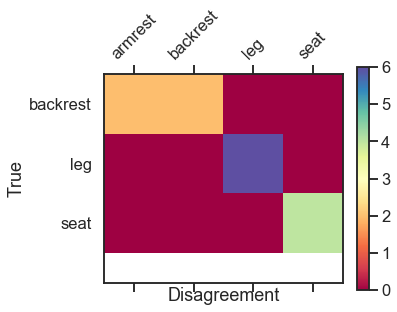

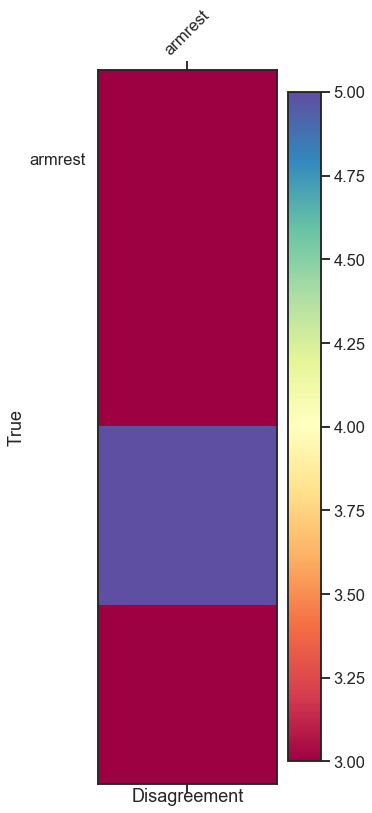

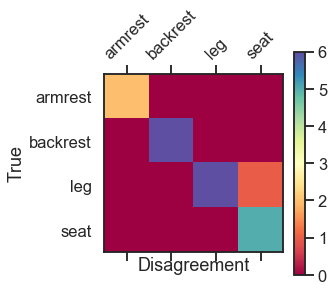

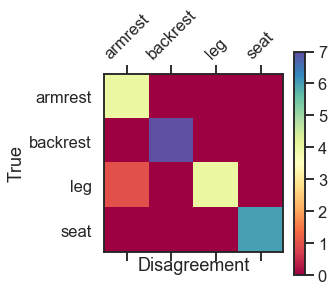

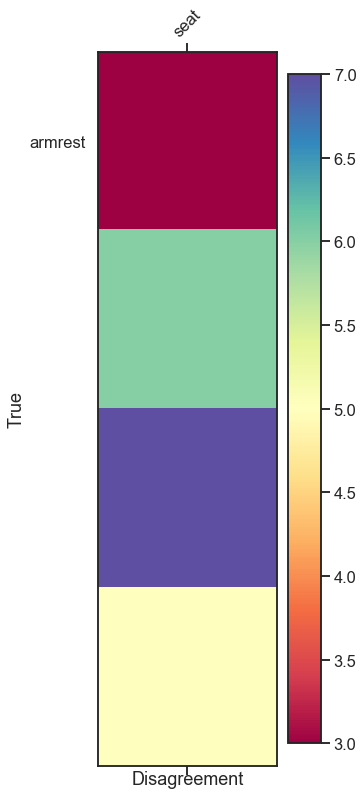

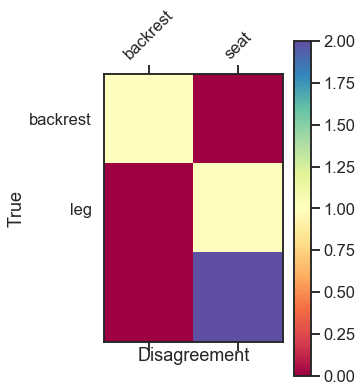

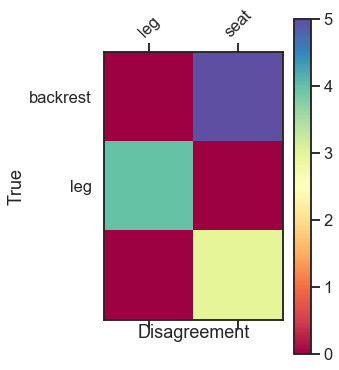

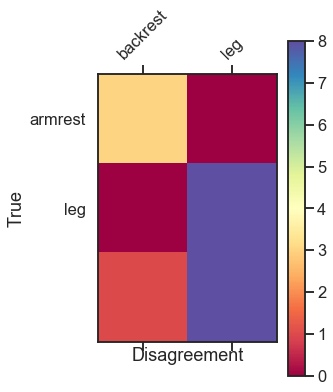

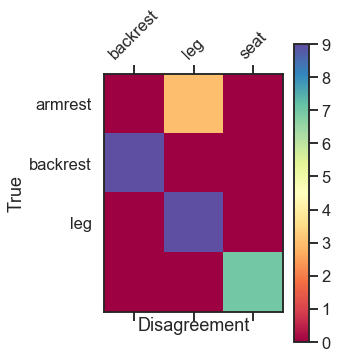

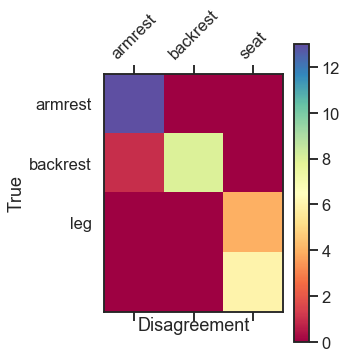

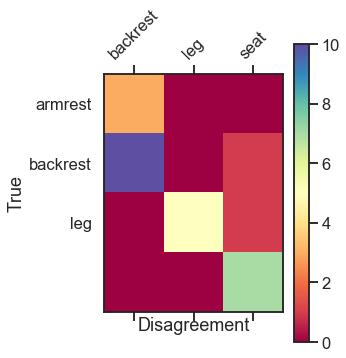

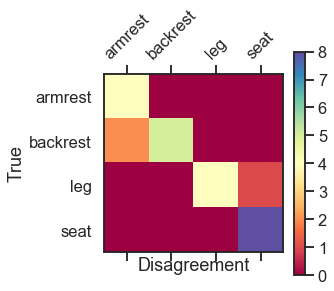

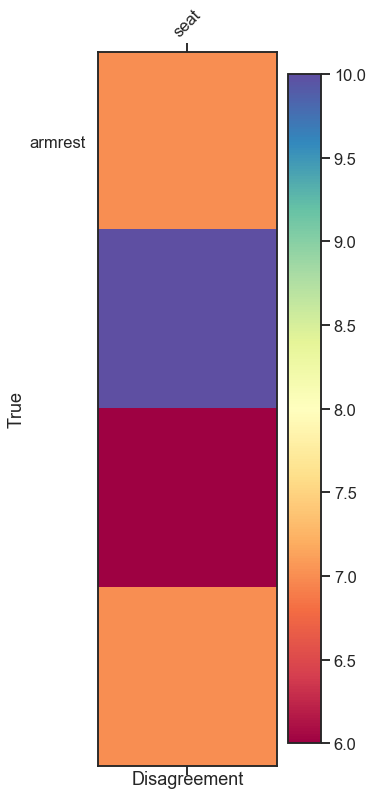

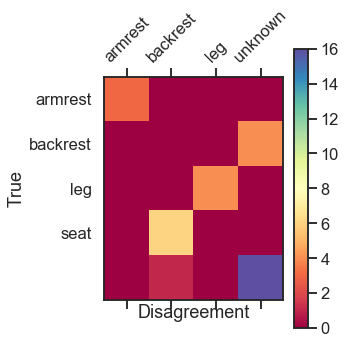

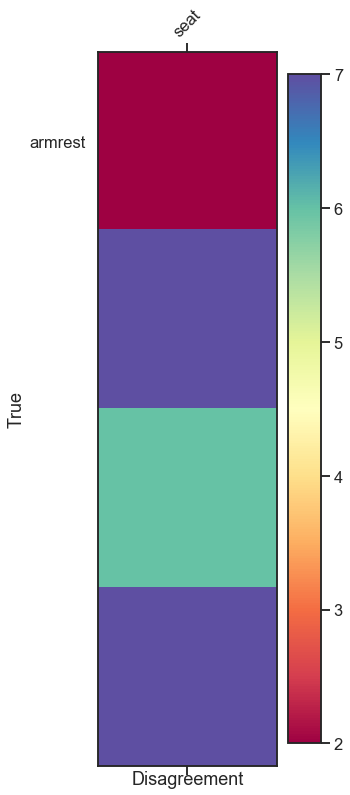

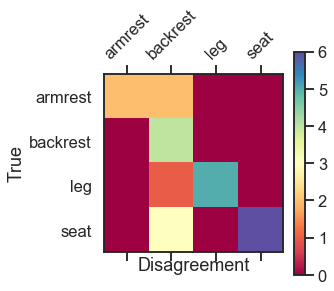

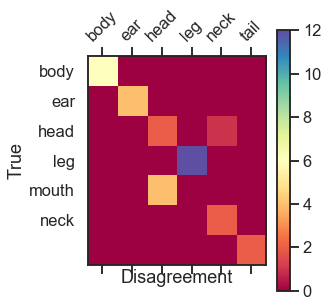

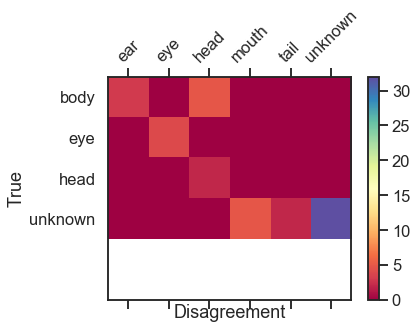

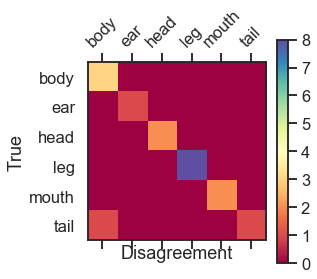

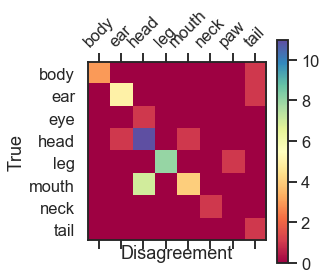

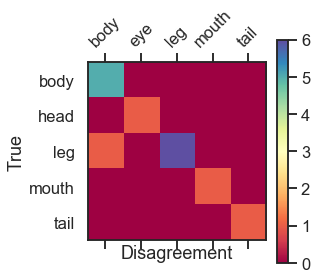

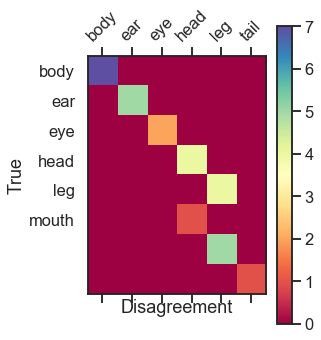

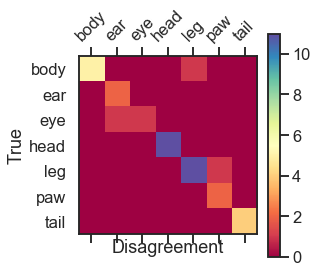

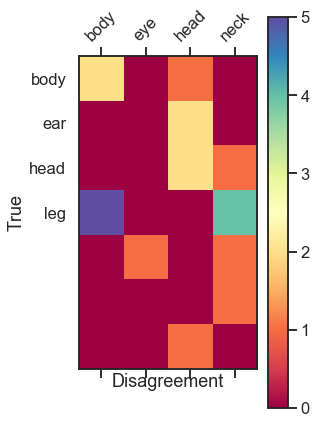

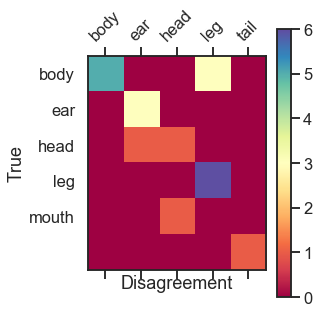

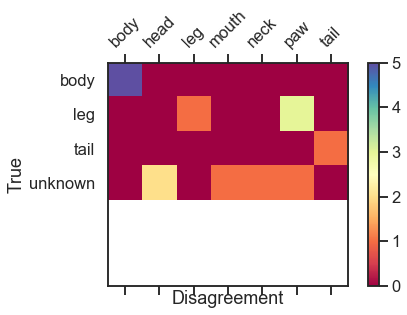

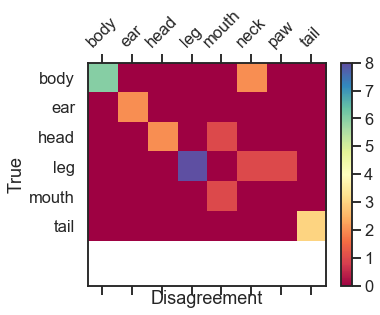

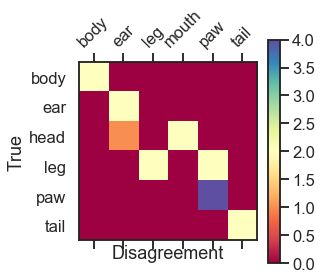

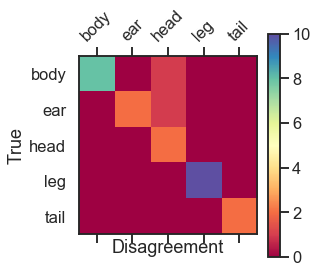

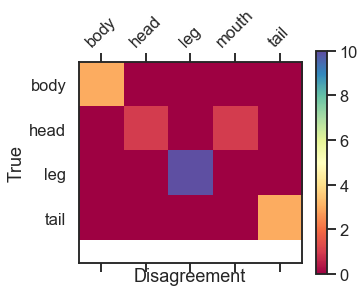

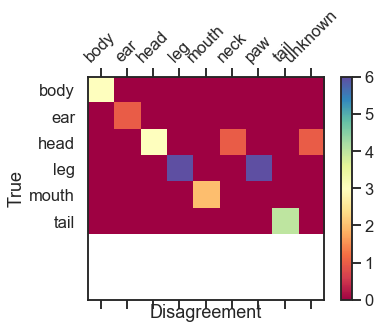

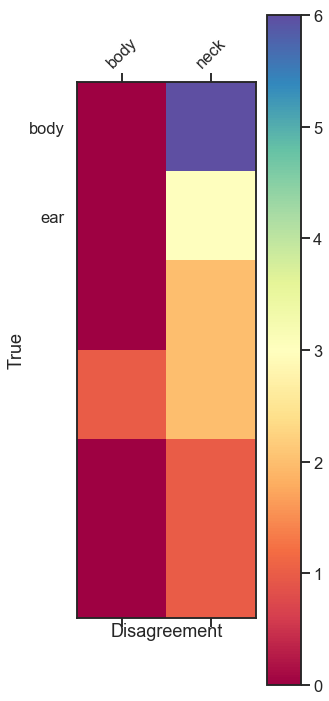

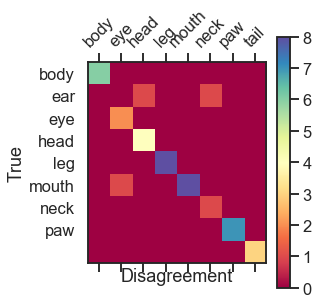

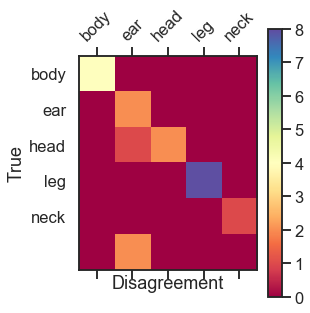

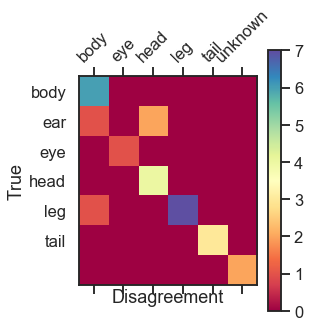

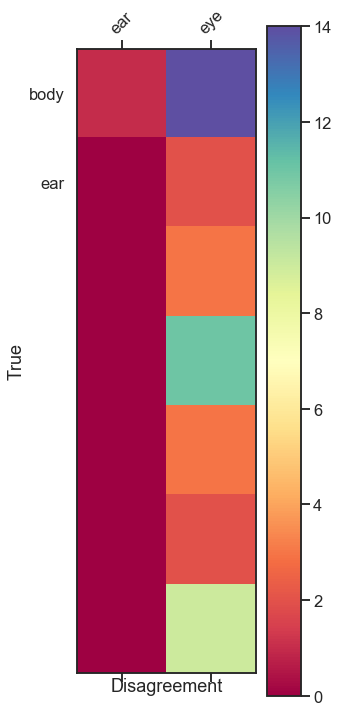

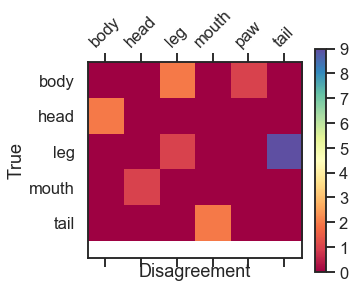

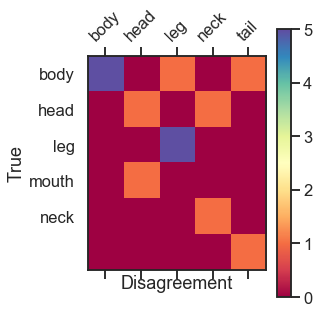

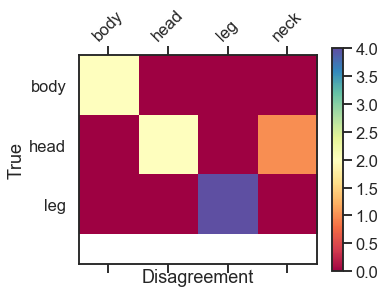

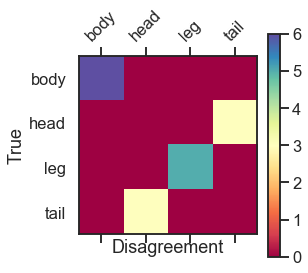

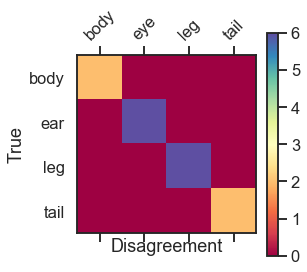

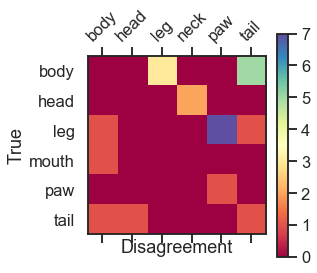

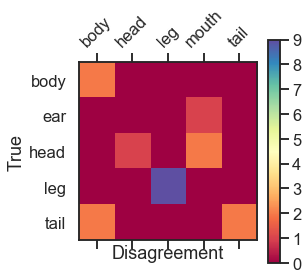

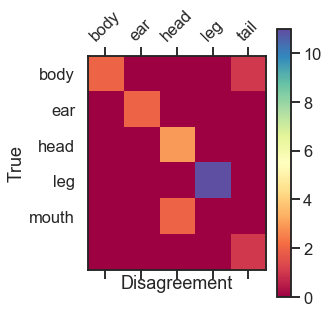

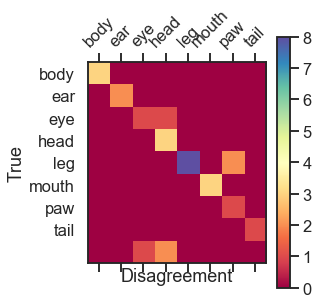

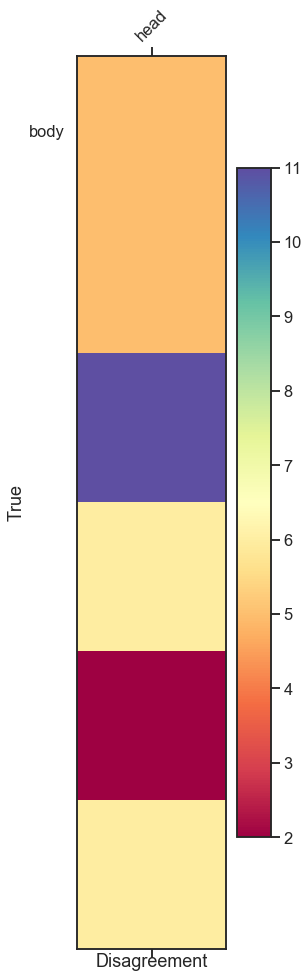

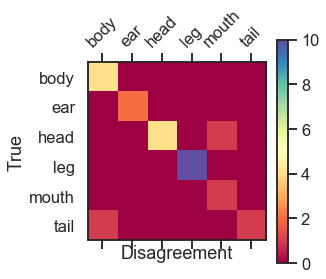

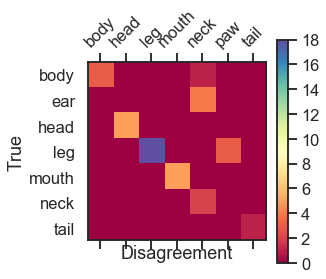

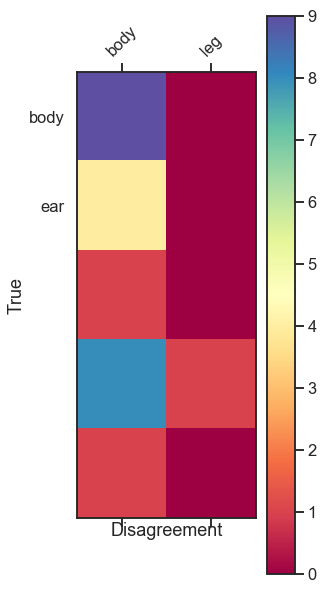

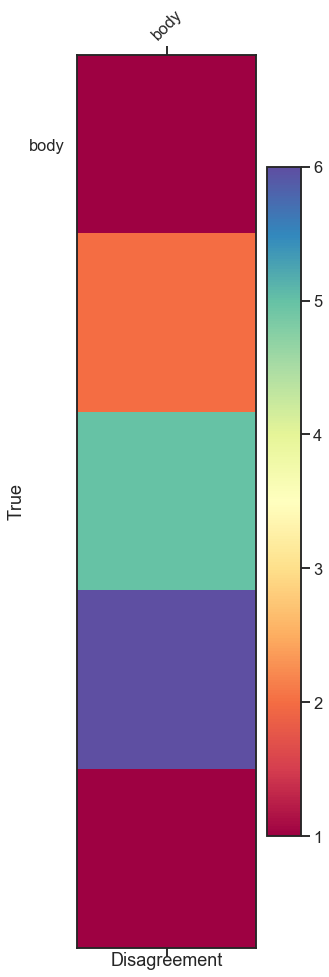

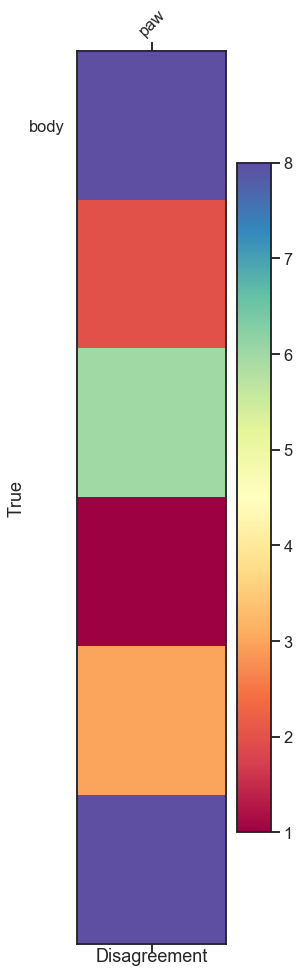

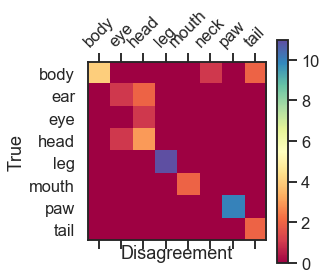

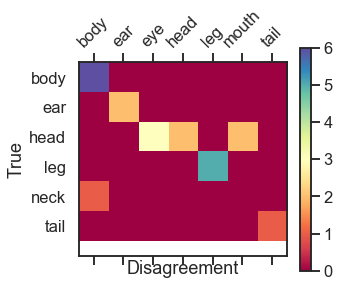

In [62]:
for this_cat in unique_cats:
    DS= D[D['category']==this_cat]
    for this_sketch in DS.sketch_id.unique():
        _sketch= DS[DS['sketch_id']==this_sketch]
        for this_spline in _sketch.spline_id.unique():
            _spline= _sketch[_sketch['spline_id']==this_spline]
            if _spline.label.nunique()==2:
                counts= _spline['label'].value_counts()
                deviant_label= counts[counts==1].index.values.tolist()[0] 
                deviant_sketch,deviant_annotation=_spline[_spline['label']==deviant_label].sketch_id, _spline[_spline['label']==deviant_label].annotation_id
                deviant_partlist=pd.Series(D[D['annotation_id']==deviant_annotation.values[0]].sort_values('spline_id').label.tolist(), name='Disagreement')
                true_partlist = pd.Series(spline_df[spline_df['sketch_id']==deviant_sketch.values[0]].sort_values('spline_id').label.tolist(), name='True')
                cm= pd.crosstab(true_partlist, deviant_partlist)
                plot_CM(cm)
            break
                

In [63]:
todraw=D[D['annotation_id']=='9840-46b175c7-8715-49fe-99a6-0dae8776ef1b_4_3VHHR074H4VXIPYDKQ9B1VV07DF7L1'].sketch_svg_string.iloc[0]

In [64]:
todraw= [item for sublist in todraw for item in sublist]

In [65]:
todraw = "".join(todraw)

In [66]:
from PIL import Image
import aggdraw


In [67]:

# setup
img = Image.new("RGBA", (512,512)) # last part is image dimensions
draw = aggdraw.Draw(img)
outline = aggdraw.Pen("black", 5) # 5 is the outlinewidth in pixels
#fill = aggdraw.Brush("white")

# the pathstring:
#m for starting point
#c for bezier curves
#z for closing up the path, optional
#(all lowercase letters for relative path)
pathstring=todraw

# create symbol
symbol = aggdraw.Symbol(pathstring)

# draw and save it
xy = (100,100) # xy position to place symbol
draw.symbol(xy, symbol, outline, fill)
draw.flush()
 
img.save("testbeziercurves.png") # this image gets saved to same folder as the script

print "finished drawing and saved!"

NameError: name 'fill' is not defined

In [ ]:


sample = D[D['annotation_id']=='2323-a9c585ff-0096-4f9c-8be4-e202993c654f_8_3VD82FOHKR2B0RW6OZXE9YR83S4OCJ']
print sample.stroke_num, sample.label

In [ ]:

stroke_df[stroke_df.sketch_id == sample.sketch_id.iloc[0]]
